In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import copy
import torch
import warnings
from torch_geometric.utils import lexsort
import os

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
def get_2D_ttc_circles_cuda_batched(
    ego_pos, ego_vel, ego_dim,
    foe_pos, foe_vel, foe_dim,
    buffer_coef=np.sqrt(2),
    bubble=0,
    batch_size=None
):
    """
    Compute Time-To-Collision (TTC) using multiple-circle approximation with CUDA batch processing.
    Prevents CUDA OOM errors by processing in batches.
    
    Args:
        ego_pos: (N, 2) tensor - Ego vehicle positions (x, y).
        ego_vel: (N, 2) tensor - Ego vehicle velocities (Vx, Vy).
        ego_dim: (N, 2) tensor - Ego vehicle dimensions (Length, Width).
        foe_pos: (N, 2) tensor - Foe vehicle positions (x, y).
        foe_vel: (N, 2) tensor - Foe vehicle velocities (Vx, Vy).
        foe_dim: (N, 2) tensor - Foe vehicle dimensions (Length, Width).
        buffer_coef: Scaling factor for safety buffer (default sqrt(2)).
        batch_size: Number of samples per batch (auto-calculated if None).

    Returns:
        ttc: (N,) tensor - Minimum Time-To-Collision values for each vehicle pair.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    buffer_coef=(torch.tensor(buffer_coef, device='cuda'))
    # Move input tensors to the correct device
    ego_pos = ego_pos.to(dtype=torch.float32, device=device)
    ego_vel = ego_vel.to(dtype=torch.float32, device=device)
    ego_dim = ego_dim.to(dtype=torch.float32, device=device)

    foe_pos = foe_pos.to(dtype=torch.float32, device=device)
    foe_vel = foe_vel.to(dtype=torch.float32, device=device)
    foe_dim = foe_dim.to(dtype=torch.float32, device=device)

    N = ego_pos.shape[0]

    # Auto-adjust batch size if not provided
    if batch_size is None:
        batch_size = min(500000, N)  # Default: 500K samples per batch
        batch_size = max(N, 1)

    num_batches = (N + batch_size - 1) // batch_size  # Compute number of batches
    ttc_results = torch.empty(N, device=device, dtype=torch.float32)  # Allocate space

    for i in trange(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, N)

        # Slice batch
        ego_pos_batch = ego_pos[start_idx:end_idx]
        ego_vel_batch = ego_vel[start_idx:end_idx]
        ego_dim_batch = ego_dim[start_idx:end_idx]

        foe_pos_batch = foe_pos[start_idx:end_idx]
        foe_vel_batch = foe_vel[start_idx:end_idx]
        foe_dim_batch = foe_dim[start_idx:end_idx]

        # Compute TTC for batch
        ttc_batch = get_2D_ttc_circles_cuda(
            ego_pos_batch, ego_vel_batch, ego_dim_batch,
            foe_pos_batch, foe_vel_batch, foe_dim_batch,
            buffer_coef, bubble=bubble
        )

        # Store results
        ttc_results[start_idx:end_idx] = ttc_batch

    return ttc_results


def get_approximate_circles_cuda(pos, dim, device="cuda"):
    """
    Approximates a rectangular vehicle as a series of circles along its length.
    Returns a tensor of shape (N, max_circles, 2) containing circle centers.
    """
    x, y = pos[:, 0], pos[:, 1]
    L, W = dim[:, 0], dim[:, 1]

    # Number of circles (at least 1, up to L/W)
    num_circles = torch.ceil(L / W).to(torch.int32)
    max_circles = num_circles.max().item()

    # Compute x positions for circles
    start_x = x - L / 2 + W / 2
    end_x = x + L / 2 - W / 2
    step = (end_x - start_x) / (num_circles - 1).clamp(min=1)

    # Generate indices for evenly spaced circles
    indices = torch.arange(max_circles, device=device).unsqueeze(0)
    valid_mask = indices < num_circles.unsqueeze(1)

    # Compute circle positions
    x_positions = start_x.unsqueeze(1) + indices * step.unsqueeze(1)  # Shape: (N, max_circles)
    y_positions = y.unsqueeze(1).expand(-1, max_circles).clone()  # Keep y constant

    # Mask invalid circles
    x_positions[~valid_mask] = torch.nan
    y_positions[~valid_mask] = torch.nan

    return torch.stack([x_positions, y_positions], dim=-1)  # Shape: (N, max_circles, 2)

def get_2D_ttc_circles_cuda(
    ego_pos, ego_vel, ego_dim,
    foe_pos, foe_vel, foe_dim,
    buffer_coef=torch.sqrt(torch.tensor(2.0, device='cuda')),
    bubble=0
):
    """
    Compute Time-To-Collision (TTC) between vehicles approximated as multiple circles using CUDA acceleration.
    Assumes zero acceleration.
    
    Args:
        ego_pos: (N, 2) tensor - Ego vehicle positions (x, y).
        ego_vel: (N, 2) tensor - Ego vehicle velocities (Vx, Vy).
        ego_dim: (N, 2) tensor - Ego vehicle dimensions (Length, Width).
        foe_pos: (N, 2) tensor - Foe vehicle positions (x, y).
        foe_vel: (N, 2) tensor - Foe vehicle velocities (Vx, Vy).
        foe_dim: (N, 2) tensor - Foe vehicle dimensions (Length, Width).
        buffer_coef: Scaling factor for safety buffer (default sqrt(2)).

    Returns:
        ttc: (N,) tensor - Minimum Time-To-Collision values for each vehicle pair.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure tensors are on GPU
    ego_pos = ego_pos.clone().detach().to(dtype=torch.float32, device=device)
    ego_vel = ego_vel.clone().detach().to(dtype=torch.float32, device=device)
    ego_dim = ego_dim.clone().detach().to(dtype=torch.float32, device=device)

    foe_pos = foe_pos.clone().detach().to(dtype=torch.float32, device=device)
    foe_vel = foe_vel.clone().detach().to(dtype=torch.float32, device=device)
    foe_dim = foe_dim.clone().detach().to(dtype=torch.float32, device=device)

    # Compute circle centers for each vehicle
    ego_circles = get_approximate_circles_cuda(ego_pos, ego_dim, device)  # (N, C, 2)
    foe_circles = get_approximate_circles_cuda(foe_pos, foe_dim, device)  # (N, C, 2)

    # Compute circle radii based on vehicle width
    ego_r = (ego_dim[:, 1] / 2) * buffer_coef + bubble  # Shape: (N,)
    foe_r = (foe_dim[:, 1] / 2) * buffer_coef + bubble # Shape: (N,)
    total_r = ego_r.unsqueeze(1).unsqueeze(1) + foe_r.unsqueeze(1).unsqueeze(1)  # (N, 1, 1)

    # Compute all pairwise circle distances
    ego_exp = ego_circles.unsqueeze(2)  # (N, C, 1, 2)
    foe_exp = foe_circles.unsqueeze(1)  # (N, 1, C, 2)

    rel_pos = ego_exp - foe_exp  # Shape: (N, C, C, 2)
    rel_vel = ego_vel.unsqueeze(1).unsqueeze(1) - foe_vel.unsqueeze(1).unsqueeze(1)  # (N, 1, 1, 2)

    # Compute quadratic coefficients
    A = (rel_vel[..., 0]**2 + rel_vel[..., 1]**2)  # (N, C, C)
    B = 2 * (rel_pos[..., 0] * rel_vel[..., 0] + rel_pos[..., 1] * rel_vel[..., 1])  # (N, C, C)
    C = (rel_pos[..., 0]**2 + rel_pos[..., 1]**2 - total_r**2)  # (N, C, C)

    # Compute discriminant
    discriminant = B**2 - 4 * A * C
    # valid_mask = discriminant >= 0  # Valid solutions where discriminant is non-negative

    # sqrt_disc = torch.sqrt(torch.clamp(discriminant, min=0))  # Avoid NaNs

    sqrt_disc = torch.sqrt(discriminant)
    t1 = (-B + sqrt_disc) / (2 * A) 
    t2 = (-B - sqrt_disc) / (2 * A) 

    # Find the smallest positive TTC
    t1[t1 < 0] = float('inf')
    t2[t2 < 0] = float('inf')

    ttc = torch.min(t1, t2)  # Minimum positive solution for each circle pair

    # overlap mask 
    overlap_mask = C < 0
    ttc[overlap_mask] = 0
    
    # Handle invalid cases correctly
    ttc[torch.isnan(ttc)] = float('inf')  # Replace NaNs
    min_ttc = torch.amin(ttc, dim=(1, 2))  # Min over all circle interactions

    # Mask invalid results
    min_ttc = torch.clamp(min_ttc, max=1e9)  # Large value for "no collision"

    return min_ttc

In [4]:
def modified_ttc_vectorized(x_f, v_f, a_f, w_f, x_l, v_l, a_l, w_l, dir, eps=1e-6):
    """
    Compute the modified time-to-collision (TTC) between the following (ego) vehicle
    and the leading vehicle, given their longitudinal positions (x),
    speeds (v), and accelerations (a). The calculation is vectorized.
    
    Parameters:
      x_f : np.array
         Longitudinal positions (centers) of the following vehicle.
      v_f : np.array
         Longitudinal speeds of the following vehicle (nonnegative).
      a_f : np.array
         Longitudinal acceleration rates for the following vehicle.
         (When negative, the vehicle decelerates but does not go below 0 speed.)
      x_l : np.array
         Longitudinal positions (centers) of the leading vehicle.
      v_l : np.array
         Longitudinal speeds of the leading vehicle.
      a_l : np.array
         Longitudinal acceleration rates for the leading vehicle.
         (When negative, the vehicle decelerates but does not go below 0 speed.)
      dir : np.array
         1 or -1, indicator of vehicle driving directions
      eps : float
         A small number to avoid division by zero for equal accelerations.
         
    Returns:
      ttc : np.array
         The modified time-to-collision for each set of input values.
         If a collision is not predicted (or not possible), the output is np.inf.
         
    Notes
    -----
    - Collision is defined as the time when x_f(t) == x_l(t). For the time period in which
      both vehicles are moving under the given acceleration, the positions evolve as:
      
          x(t) = x0 + v*t + 0.5*a*t^2
      
      Once a vehicle decelerates to 0 speed (if a < 0), its position is held constant.
      
    - The function first computes a candidate collision time (t_candidate) by solving
      the quadratic for the continuous phase. It then checks if this candidate occurs before
      either vehicle would have stopped (t_stop_f and t_stop_l). If not, the effective positions
      at the earliest stop time are computed. If a collision occurs by that time, that stop time
      is returned; otherwise, we set TTC = np.inf.
      
    - For cases where no collision is possible (e.g. when v_f <= v_l or x_l - x_f <= 0),
      np.inf is returned.
    """
    # Ensure inputs are numpy arrays:
    x_f = np.asarray(x_f, dtype=float) *dir
    v_f = np.asarray(v_f, dtype=float) *dir
    a_f = np.asarray(a_f, dtype=float) *dir
    x_l = np.asarray(x_l, dtype=float) *dir
    v_l = np.asarray(v_l, dtype=float) *dir
    a_l = np.asarray(a_l, dtype=float) *dir

    w_f = np.asarray(w_f, dtype=float)
    w_l = np.asarray(w_l, dtype=float)
    
    # Compute the gap (assume x_l > x_f for collision to be possible)
    d = (x_l - x_f) - (w_l/2 + w_f/2)
    
    # Initialize TTC as infinity.
    ttc = np.full(x_f.shape, np.inf, dtype=float)
    
    # For collision to be possible, the gap must be > 0 and the following must be faster.
    valid = (d > 0) 

    # Vehicles collided already?
    collide = abs(x_l - x_f) < (w_l/2 + w_f/2)
    
    # Compute time to stop (if decelerating, else infinity)
    t_stop_f = np.where(a_f < 0, v_f / (-a_f), np.inf)
    t_stop_l = np.where(a_l < 0, v_l / (-a_l), np.inf)
    
    # Initialize candidate TTC array
    t_candidate = np.full(x_f.shape, np.inf, dtype=float)
    
    # For vehicles with nearly equal accelerations, use linear equation.
    same_accel = np.abs(a_f - a_l) < eps

    # For vehicle with nearly equal velocities, 
    same_vel = np.abs(v_f - v_l) < eps

    # Follower faster
    follower_faster = (v_f - v_l) > eps

    # Where accelerations are nearly equal:
    t_candidate[same_accel & valid & follower_faster] = d[same_accel & valid & follower_faster] / (v_f[same_accel & valid & follower_faster] - v_l[same_accel & valid & follower_faster])
    
    # For the others, solve the quadratic
    not_same = ~same_accel & valid
    # Discriminant for quadratic: (v_f - v_l)^2 + 2*(a_f - a_l)*d
    disc = (v_f[not_same] - v_l[not_same])**2 + 2*(a_f[not_same] - a_l[not_same]) * d[not_same]
    
    # Only consider real solutions (disc must be nonnegative)
    valid_disc = disc >= 0
    sol = np.full(np.count_nonzero(not_same), np.inf, dtype=float)
    sol[valid_disc] = ((- (v_f[not_same][valid_disc] - v_l[not_same][valid_disc]) +
                         np.sqrt(disc[valid_disc]))
                       / (a_f[not_same][valid_disc] - a_l[not_same][valid_disc]))
    # In any case, we want only positive times:
    sol = np.where(sol > 0, sol, np.inf)
    t_candidate[not_same] = sol
    
    # Now, if the candidate occurs before either vehicle stops,
    # it is accepted; otherwise, use the earliest stop time.
    use_candidate = (t_candidate <= t_stop_f) & (t_candidate <= t_stop_l)
    
    # For valid inputs that meet the candidate criterion, assign ttc = t_candidate.
    ttc = np.where(valid & use_candidate, t_candidate, ttc)
    
    # For those valid cases that did not use the candidate (i.e. at least one vehicle would hit 0 speed first):
    not_candidate = valid & ~use_candidate
    # t_min: the time when the first vehicle stops (follower or leader)
    t_min = np.minimum(t_stop_f, t_stop_l)
    # Compute effective positions at t_min.
    # (Using the kinematic formula only if t_min is finite.)
    x_f_eff = np.where(np.isfinite(t_min), x_f + v_f*t_min + 0.5*a_f*t_min**2, x_f)
    x_l_eff = np.where(np.isfinite(t_min), x_l + v_l*t_min + 0.5*a_l*t_min**2, x_l)
    
    # If by t_min the following vehicle reaches or exceeds the leader's position, then collision occurs.
    collision_at_stop = x_f_eff >= x_l_eff
    ttc = np.where(not_candidate & collision_at_stop, t_min, ttc)

    # if collided at the begining, overwrite with 0
    ttc[collide] = 0

    # if both accel and vel are similar, overwrite with inf
    ttc[valid & same_accel & same_vel] = np.inf
    
    # For any cases not meeting "valid" (e.g. follower not closing or gap not positive),
    # ttc remains infinity.
    return ttc

In [5]:
def prepare_data_per_recording_2d(recording_id, distillframeinterval=5, lanechangewindow=25):
    tracks = pd.read_csv(f"E:/Data/highd-dataset-v1.0/data/{recording_id:02}_tracks.csv")
    distilled_frames = np.arange(tracks.frame.min(), tracks.frame.max(), distillframeinterval)
    distilled_tracks = tracks[tracks.frame.isin(distilled_frames)]
    # check if lane change will happen
    pre_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    pos_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    lanechangewindowframes = int(lanechangewindow / distillframeinterval)
    for dt in range(1, lanechangewindowframes+1):
        pre_mask = np.zeros(len(distilled_tracks), dtype=bool)
        pos_mask = np.zeros(len(distilled_tracks), dtype=bool)
        checklanes = (distilled_tracks.laneId.values[dt:] != distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
        pre_mask[:-dt] = checklanes
        pos_mask[dt:] = checklanes
        pre_lc_mask += pre_mask
        pos_lc_mask += pos_mask
    # get the lane changing indicator
    distilled_tracks.loc[:,'preLaneChange'] = pre_lc_mask.astype(int)
    distilled_tracks.loc[:,'posLaneChange'] = pos_lc_mask.astype(int)
    # get the direction indicator
    veh_mean_speed = distilled_tracks.groupby('id').xVelocity.transform('mean').values
    dir = (veh_mean_speed / np.abs(veh_mean_speed)).astype('int')
    distilled_tracks.loc[:,'dir'] = dir
    # rectify the vehicle positions
    distilled_tracks.loc[:,'_x'] = distilled_tracks.x + 0.5*distilled_tracks.width
    distilled_tracks.loc[:,'_y'] = distilled_tracks.y + 0.5*distilled_tracks.height

    def count_in_range(x_array, r=50):
        # Create a 2D difference matrix (each element |x_i - x_j|)
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        # For each row, count how many differences are <= r.
        return (diff_matrix <= r).sum(axis=1)

    # Apply the function for each frame using groupby-transform:
    vehicle_counts_nearby = distilled_tracks.groupby(["frame","dir"])["_x"].transform(lambda s: count_in_range(s.values, r=1e8))
    # Get segment length
    segment_length = distilled_tracks.x.max() - distilled_tracks.x.min()
    neighbor_nlanes = distilled_tracks.groupby("dir").laneId.transform('nunique').values
    # get nearby densities
    neighbor_densities = vehicle_counts_nearby / segment_length / neighbor_nlanes * 1000

    def compute_mean_velocity_for_group(group, r=5):
        # Get arrays for x positions and xVelocity
        x_array = group["x"].values
        vel_array = group["xVelocity"].values
        
        # Compute pairwise absolute differences in x positions via broadcasting
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        
        # Boolean mask: True when difference is within r
        in_range_mask = diff_matrix <= r
        
        # For each row, compute the mean xVelocity of vehicles in range
        mean_vel = (in_range_mask * vel_array[None, :]).sum(axis=1) / in_range_mask.sum(axis=1)
        return mean_vel

    def compute_mean_velocity_for_all(df, r=5):
        """
        Compute, for each row in df, the mean of xVelocity for nearby vehicles (|x_i - x|<=r) in the same frame.
        Returns a Series with the same index as df.
        """
        # Group by frame; each group contains vehicles in that frame.
        # For each group, compute mean velocities and return a Series with the same index as the group.
        grouped_series = df.groupby(["frame","dir"], group_keys=False).apply(
            lambda group: pd.Series(compute_mean_velocity_for_group(group, r), index=group.index)
        )
        # Reindex to ensure the order matches df exactly
        return grouped_series.reindex(df.index)

    # Compute the mean xVelocity for nearby vehicles for each row,
    # ensuring that the output Series has the same order as df.
    mean_vel_series = compute_mean_velocity_for_all(distilled_tracks, r=1e8)

    df = copy.deepcopy(distilled_tracks)
    df = df.reset_index().rename(columns={'index': 'orig_index'})
    # Prepare a helper DataFrame that represents the "leader" rows.
    # We rename 'id' to 'leader_id' to differentiate it in the merge.
    leader_df = df[['orig_index', 'frame', 'id']].rename(columns={'id': 'leader_id'})
    # Merge the DataFrame with the leader_df.
    # The merge is done on:
    #  - "frame": so that we only match vehicles in the same frame.
    #  - "precedingId" from the left DataFrame with "leader_id" from the right.
    # This yields, for each row, a new column 'orig_index_y' that is the index of the leader row.
    merged = df.merge(
        leader_df,
        left_on=['frame', 'precedingId'],
        right_on=['frame', 'leader_id'],
        how='left'
    )
    # Add a new column to the original DataFrame:
    # 'leader_index' now contains, for each row, the index of its corresponding leading vehicle.
    df['leader_index'] = merged['orig_index_y']
    leader_index = df.leader_index.values
    # get the interaction mask
    interaction_mask = ~np.isnan(leader_index)
    # aggregation dataframe of tracks
    expanded_tracks = copy.deepcopy(distilled_tracks)
    expanded_tracks['localVelocity'] = mean_vel_series.abs().values
    expanded_tracks['localDensity'] = neighbor_densities

    # ego data -- the following vehicle data
    # foe data -- the leading vehicle data
    ego_data = distilled_tracks[interaction_mask]
    foe_data = distilled_tracks.loc[leader_index[interaction_mask]]

    # we need these variables
    ego_vel = ego_data.xVelocity.abs().values
    foe_vel = foe_data.xVelocity.abs().values

    ego_accel = ego_data.xAcceleration.values * ego_data.dir.values
    foe_accel = foe_data.xAcceleration.values * foe_data.dir.values

    ego_preLc = ego_data.preLaneChange.values
    ego_posLc = ego_data.posLaneChange.values
    foe_preLc = foe_data.preLaneChange.values
    foe_posLc = foe_data.posLaneChange.values

    ego_length = ego_data.width.values
    foe_length = foe_data.width.values

    original_ttc = copy.deepcopy(ego_data.ttc.values)
    original_ttc[original_ttc <=0] = np.inf

    ego_localspeed = expanded_tracks.localVelocity[interaction_mask].values
    foe_localspeed = expanded_tracks.localVelocity.loc[leader_index[interaction_mask]].values

    ego_localdensity = expanded_tracks.localDensity[interaction_mask].values
    foe_localdensity = expanded_tracks.localDensity.loc[leader_index[interaction_mask]].values

    mttc = modified_ttc_vectorized(ego_data._x, ego_data.xVelocity, ego_data.xAcceleration, ego_data.width, 
                            foe_data._x, foe_data.xVelocity, foe_data.xAcceleration, foe_data.width,
                            ego_data.dir
                            )

    neighbor_nlanes = distilled_tracks.groupby("dir").laneId.transform('nunique').values
    maxlaneid = distilled_tracks.groupby("dir").laneId.transform('max')
    minlaneid = distilled_tracks.groupby("dir").laneId.transform('min')

    lower = np.clip(distilled_tracks.dir, a_min=0, a_max=1)

    which_lane = (distilled_tracks.laneId - minlaneid) * lower + (maxlaneid - distilled_tracks.laneId) * (1-lower)

    ego_local_nlanes = neighbor_nlanes[interaction_mask]
    ego_which_lane = which_lane[interaction_mask]

    recordingIds = np.full(len(ego_data), recording_id)

    egoIds = ego_data.id.values
    foeIds = foe_data.id.values

    frameIds = ego_data.frame.values


    dataframe = pd.DataFrame(data={
        'ego_vel': ego_vel,
        'foe_vel': foe_vel,
        'ego_accel': ego_accel,
        'foe_accel': foe_accel,
        'ego_pre_lc': ego_preLc,
        'foe_pre_lc': foe_preLc,
        'ego_pos_lc': ego_posLc,
        'foe_pos_lc': foe_posLc,
        'ego_local_speed': ego_localspeed,
        'foe_local_speed': foe_localspeed,
        'ego_local_density': ego_localdensity,
        'foe_local_density': foe_localdensity,
        'ego_length': ego_length,
        'foe_length': foe_length,
        'recording_id': recordingIds,
        'ego_id': egoIds,
        'foe_id': foeIds,
        'frame': frameIds,
        'nlanes': ego_local_nlanes,
        'which_lane': ego_which_lane,
        'dir': ego_data.dir.values,
        'mttc': mttc,
        'ottc': original_ttc,
    })

    return dataframe

In [6]:
def prepare_data_per_recording(recording_id, distillframeinterval=5, lanechangewindow=25):
    tracks = pd.read_csv(f"E:/Data/highd-dataset-v1.0/data/{recording_id:02}_tracks.csv")
    distilled_frames = np.arange(tracks.frame.min(), tracks.frame.max(), distillframeinterval)
    distilled_tracks = tracks[tracks.frame.isin(distilled_frames)]
    # check if lane change will happen
    pre_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    pos_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    lanechangewindowframes = int(lanechangewindow / distillframeinterval)
    for dt in range(1, lanechangewindowframes+1):
        pre_mask = np.zeros(len(distilled_tracks), dtype=bool)
        pos_mask = np.zeros(len(distilled_tracks), dtype=bool)
        checklanes = (distilled_tracks.laneId.values[dt:] != distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
        pre_mask[:-dt] = checklanes
        pos_mask[dt:] = checklanes
        pre_lc_mask += pre_mask
        pos_lc_mask += pos_mask
    # get the lane changing indicator
    distilled_tracks.loc[:,'preLaneChange'] = pre_lc_mask.astype(int)
    distilled_tracks.loc[:,'posLaneChange'] = pos_lc_mask.astype(int)
    # get the direction indicator
    veh_mean_speed = distilled_tracks.groupby('id').xVelocity.transform('mean').values
    dir = (veh_mean_speed / np.abs(veh_mean_speed)).astype('int')
    distilled_tracks.loc[:,'dir'] = dir
    # rectify the vehicle positions
    distilled_tracks.loc[:,'_x'] = distilled_tracks.x + 0.5*distilled_tracks.width
    distilled_tracks.loc[:,'_y'] = distilled_tracks.y + 0.5*distilled_tracks.height

    def count_in_range(x_array, r=50):
        # Create a 2D difference matrix (each element |x_i - x_j|)
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        # For each row, count how many differences are <= r.
        return (diff_matrix <= r).sum(axis=1)

    # Apply the function for each frame using groupby-transform:
    vehicle_counts_nearby = distilled_tracks.groupby(["frame","dir"])["_x"].transform(lambda s: count_in_range(s.values, r=1e8))
    # Get segment length
    segment_length = distilled_tracks.x.max() - distilled_tracks.x.min()
    neighbor_nlanes = distilled_tracks.groupby("dir").laneId.transform('nunique').values
    # get nearby densities
    neighbor_densities = vehicle_counts_nearby / segment_length / neighbor_nlanes * 1000

    def compute_mean_velocity_for_group(group, r=5):
        # Get arrays for x positions and xVelocity
        x_array = group["x"].values
        vel_array = group["xVelocity"].values
        
        # Compute pairwise absolute differences in x positions via broadcasting
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        
        # Boolean mask: True when difference is within r
        in_range_mask = diff_matrix <= r
        
        # For each row, compute the mean xVelocity of vehicles in range
        mean_vel = (in_range_mask * vel_array[None, :]).sum(axis=1) / in_range_mask.sum(axis=1)
        return mean_vel

    def compute_mean_velocity_for_all(df, r=5):
        """
        Compute, for each row in df, the mean of xVelocity for nearby vehicles (|x_i - x|<=r) in the same frame.
        Returns a Series with the same index as df.
        """
        # Group by frame; each group contains vehicles in that frame.
        # For each group, compute mean velocities and return a Series with the same index as the group.
        grouped_series = df.groupby(["frame","dir"], group_keys=False).apply(
            lambda group: pd.Series(compute_mean_velocity_for_group(group, r), index=group.index)
        )
        # Reindex to ensure the order matches df exactly
        return grouped_series.reindex(df.index)

    # Compute the mean xVelocity for nearby vehicles for each row,
    # ensuring that the output Series has the same order as df.
    mean_vel_series = compute_mean_velocity_for_all(distilled_tracks, r=1e8)

    df = copy.deepcopy(distilled_tracks)
    df = df.reset_index().rename(columns={'index': 'orig_index'})
    # Prepare a helper DataFrame that represents the "leader" rows.
    # We rename 'id' to 'leader_id' to differentiate it in the merge.
    leader_df = df[['orig_index', 'frame', 'id']].rename(columns={'id': 'leader_id'})
    # Merge the DataFrame with the leader_df.
    # The merge is done on:
    #  - "frame": so that we only match vehicles in the same frame.
    #  - "precedingId" from the left DataFrame with "leader_id" from the right.
    # This yields, for each row, a new column 'orig_index_y' that is the index of the leader row.
    merged = df.merge(
        leader_df,
        left_on=['frame', 'precedingId'],
        right_on=['frame', 'leader_id'],
        how='left'
    )
    # Add a new column to the original DataFrame:
    # 'leader_index' now contains, for each row, the index of its corresponding leading vehicle.
    df['leader_index'] = merged['orig_index_y']
    leader_index = df.leader_index.values
    # get the interaction mask
    interaction_mask = ~np.isnan(leader_index)
    # aggregation dataframe of tracks
    expanded_tracks = copy.deepcopy(distilled_tracks)
    expanded_tracks['localVelocity'] = mean_vel_series.abs().values
    expanded_tracks['localDensity'] = neighbor_densities

    # ego data -- the following vehicle data
    # foe data -- the leading vehicle data
    ego_data = distilled_tracks[interaction_mask]
    foe_data = distilled_tracks.loc[leader_index[interaction_mask]]

    # we need these variables
    ego_vel = ego_data.xVelocity.abs().values
    foe_vel = foe_data.xVelocity.abs().values

    ego_accel = ego_data.xAcceleration.values * ego_data.dir.values
    foe_accel = foe_data.xAcceleration.values * foe_data.dir.values

    ego_preLc = ego_data.preLaneChange.values
    ego_posLc = ego_data.posLaneChange.values
    foe_preLc = foe_data.preLaneChange.values
    foe_posLc = foe_data.posLaneChange.values

    ego_length = ego_data.width.values
    foe_length = foe_data.width.values

    original_ttc = copy.deepcopy(ego_data.ttc.values)
    original_ttc[original_ttc <=0] = np.inf

    ego_localspeed = expanded_tracks.localVelocity[interaction_mask].values
    foe_localspeed = expanded_tracks.localVelocity.loc[leader_index[interaction_mask]].values

    ego_localdensity = expanded_tracks.localDensity[interaction_mask].values
    foe_localdensity = expanded_tracks.localDensity.loc[leader_index[interaction_mask]].values

    mttc = modified_ttc_vectorized(ego_data._x, ego_data.xVelocity, ego_data.xAcceleration, ego_data.width, 
                            foe_data._x, foe_data.xVelocity, foe_data.xAcceleration, foe_data.width,
                            ego_data.dir
                            )

    neighbor_nlanes = distilled_tracks.groupby("dir").laneId.transform('nunique').values
    maxlaneid = distilled_tracks.groupby("dir").laneId.transform('max')
    minlaneid = distilled_tracks.groupby("dir").laneId.transform('min')

    lower = np.clip(distilled_tracks.dir, a_min=0, a_max=1)

    which_lane = (distilled_tracks.laneId - minlaneid) * lower + (maxlaneid - distilled_tracks.laneId) * (1-lower)

    ego_local_nlanes = neighbor_nlanes[interaction_mask]
    ego_which_lane = which_lane[interaction_mask]

    recordingIds = np.full(len(ego_data), recording_id)

    egoIds = ego_data.id.values
    foeIds = foe_data.id.values

    frameIds = ego_data.frame.values


    dataframe = pd.DataFrame(data={
        'ego_vel': ego_vel,
        'foe_vel': foe_vel,
        'ego_accel': ego_accel,
        'foe_accel': foe_accel,
        'ego_pre_lc': ego_preLc,
        'foe_pre_lc': foe_preLc,
        'ego_pos_lc': ego_posLc,
        'foe_pos_lc': foe_posLc,
        'ego_local_speed': ego_localspeed,
        'foe_local_speed': foe_localspeed,
        'ego_local_density': ego_localdensity,
        'foe_local_density': foe_localdensity,
        'ego_length': ego_length,
        'foe_length': foe_length,
        'recording_id': recordingIds,
        'ego_id': egoIds,
        'foe_id': foeIds,
        'frame': frameIds,
        'nlanes': ego_local_nlanes,
        'which_lane': ego_which_lane,
        'dir': ego_data.dir.values,
        'mttc': mttc,
        'ottc': original_ttc,
    })

    return dataframe

In [28]:
def process_highd_interaction_risk_dataset(record_range, distillframeinterval=5, lanechangewindow=25):
    warnings.filterwarnings('ignore')
    DataFrames = [ prepare_data_per_recording(record, distillframeinterval, lanechangewindow=lanechangewindow) for record in tqdm(record_range)  ]
    return pd.concat(DataFrames, ignore_index=True).reset_index()
    

In [29]:
def compute_time_until_next_ttc_below_threshold_vectorized(data, threshold=1.5, batch_size=500):
    """
    Compute the time (frames) until the next occurrence of `TTC < threshold` for each unique 
    ego-foe interaction (defined by ego_id, foe_id, recording_id).

    If the current row already has `TTC < threshold`, return 0.

    Args:
        data: (N, 5) tensor - Columns: [ego_id, foe_id, recording_id, frame_id, ttc]
        threshold: float - TTC threshold (default 1.5 seconds).
        batch_size: int - Number of unique (ego_id, foe_id, recording_id) pairs processed at once.

    Returns:
        time_until_next_ttc_below: (N,) tensor - Time until next TTC < threshold for each row, 
                                              in the original input order.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move data to GPU if available
    data = data.to(device)

    # Save original indices to restore order later
    original_indices = torch.arange(data.shape[0], device=device)

    # Extract columns
    ego_id, foe_id, recording_id, frame_id, ttc = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]

    # ✅ Step 1: Correct Multi-Column Sorting
    # Sorting by (ego_id, foe_id, recording_id, frame_id)
    sorted_indices = lexsort((frame_id, recording_id, foe_id, ego_id))

    # Apply sorting
    ego_id, foe_id, recording_id, frame_id, ttc, original_indices = (
        ego_id[sorted_indices], foe_id[sorted_indices], recording_id[sorted_indices],
        frame_id[sorted_indices], ttc[sorted_indices], original_indices[sorted_indices]
    )

    # ✅ Step 2: Identify Unique (ego_id, foe_id, recording_id) Pairs
    unique_pairs, pair_indices = torch.unique(
        torch.stack([ego_id, foe_id, recording_id], dim=1),
        dim=0, return_inverse=True
    )

    num_pairs = unique_pairs.shape[0]  # Total unique pairs
    num_batches = (num_pairs + batch_size - 1) // batch_size  # Compute number of batches

    # ✅ Step 3: Identify All Frames Where `TTC < threshold`
    below_threshold_mask = ttc < threshold  # Boolean mask where TTC < threshold
    valid_frame_ids = frame_id[below_threshold_mask]  # Frames where `TTC < threshold`
    valid_pair_indices = pair_indices[below_threshold_mask]  # Matching pair indices

    # Initialize the result tensor
    time_until_next_ttc_below = torch.full_like(frame_id, float('inf'), device=device)

    # ✅ Step 4: Process in Batches to Reduce Memory Usage
    for batch_idx in trange(num_batches):
        # Get the current batch of pairs
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_pairs)
        batch_pair_indices = torch.arange(start_idx, end_idx, device=device)

        # Get mask for rows belonging to this batch
        batch_mask = (pair_indices >= start_idx) & (pair_indices < end_idx)

        if batch_mask.sum() == 0:  # Skip if no data in batch
            continue

        # Get the frame_ids of the current batch
        batch_frame_ids = frame_id[batch_mask]

        # Get the valid events that belong to this batch
        batch_valid_mask = (valid_pair_indices >= start_idx) & (valid_pair_indices < end_idx)
        batch_valid_frame_ids = valid_frame_ids[batch_valid_mask]
        batch_valid_pair_indices = valid_pair_indices[batch_valid_mask]

        if batch_valid_frame_ids.numel() == 0:  # Skip empty batches
            continue

        # Compute `valid_frame_ids - frame_id` in a batched, vectorized manner
        all_time_diffs = batch_valid_frame_ids.unsqueeze(0) - batch_frame_ids.unsqueeze(1)  # (batch_size, num_valid_events)
        all_time_diffs[all_time_diffs <= 0] = float('inf')  # Ignore past events  

        # ✅ Step 5: Ensure we only consider valid pairs
        pair_match_mask = pair_indices[batch_mask].unsqueeze(1) == batch_valid_pair_indices.unsqueeze(0)  # Shape: (batch_size, num_valid_events)
        all_time_diffs[~pair_match_mask] = float('inf')  # Mask invalid pairs

        # Compute the minimum valid time difference per row
        min_time_diffs, _ = all_time_diffs.min(dim=1)

        # ✅ Step 6: Assign results back
        time_until_next_ttc_below[batch_mask] = min_time_diffs

    # ✅ Step 7: Post-processing
    # If the row itself is `TTC < threshold`, set time until next to `0`
    time_until_next_ttc_below[below_threshold_mask] = 0

    # If no future `TTC < threshold` exists, set time to `-1`
    time_until_next_ttc_below[time_until_next_ttc_below == float('inf')] = -1

    # ✅ Step 8: Restore Original Order
    restored_order = torch.argsort(original_indices)  # Get indices that map back to the original order
    time_until_next_ttc_below = time_until_next_ttc_below[restored_order]  # Restore order

    return time_until_next_ttc_below

def compute_transitions_vectorized_mode_1(data, thres1=1.5, thres2=3.0, device='cuda'):
    data = torch.tensor(data, device=device)

    ttc1 = compute_time_until_next_ttc_below_threshold_vectorized(data[:,(0,1,2,3,4)], threshold=thres1, batch_size=1000)
    ttc2 = compute_time_until_next_ttc_below_threshold_vectorized(data[:,(0,1,2,3,5)], threshold=thres2, batch_size=1000)

    # Step 1: Extract columns
    ego_id, foe_id, recording_id, frame_id = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    original_indices = torch.arange(data.shape[0], device=device)
    sorted_indices = lexsort((frame_id, recording_id, foe_id, ego_id))
    
    # Apply sorting
    ego_id, foe_id, recording_id, frame_id, original_indices, ttc1, ttc2 = (
        ego_id[sorted_indices], foe_id[sorted_indices], recording_id[sorted_indices],
        frame_id[sorted_indices], original_indices[sorted_indices], ttc1[sorted_indices], ttc2[sorted_indices]
    )

    # Step 2: Find unique (ego_id, foe_id, recording_id) groups
    unique_pairs, pair_indices = torch.unique(torch.stack([ego_id, foe_id, recording_id], dim=1), dim=0, return_inverse=True)

    states = torch.full_like(ttc1, 3, dtype=torch.int32, device='cuda')  # Default is state 3
    states[ttc2 == 0] = 2  # If TTC < 5, but not < 1.5
    states[ttc1 == 0] = 1  # If TTC < 1.5, override to state 1

    state_changes = (states[1:] != states[:-1])*(pair_indices[1:] == pair_indices[:-1])
    transition_indices = torch.where(state_changes)[0] + 1  # Convert to indices (offset by 1)
    
    first_frames_per_group = torch.full_like(frame_id, float('inf'))  # Initialize with large values
    first_frames_per_group = first_frames_per_group.scatter_reduce_(0, pair_indices, frame_id, reduce="amin")[:len(unique_pairs)]

    first_transition_per_group = torch.full((pair_indices.max() + 1,), torch.iinfo(torch.long).max, dtype=torch.long, device=transition_indices.device)

    # Step 3: Scatter reduce to find the first transition index per group
    first_transition_per_group.scatter_reduce_(0, pair_indices[transition_indices], transition_indices, reduce="amin")

    # Step 4: Compare transition indices with the first transition per group
    first_transition_mask = transition_indices == first_transition_per_group[pair_indices[transition_indices]]

    # Step 5: 
    n_transitions = len(transition_indices)
    transition_from_states = states[transition_indices-1]
    transition_to_states = states[transition_indices]
    transition_start_frames = torch.cat([torch.tensor([0], device=device), frame_id[transition_indices[0:n_transitions-1]]])
    transition_start_frames = transition_start_frames*~first_transition_mask + first_transition_mask*first_frames_per_group[pair_indices[transition_indices]]
    transition_end_frames = frame_id[transition_indices[0:n_transitions]] 

    transitions = torch.stack([ego_id[transition_indices], foe_id[transition_indices], recording_id[transition_indices], transition_start_frames, transition_end_frames, transition_from_states, transition_to_states], dim=1)
    return transitions


In [46]:
def get_processed_input_start_stop(data, transition, sequence=250, from_state=2, to_state=1, truck_thres=10, accel_thres=0.67, density_norm=50, speed_norm=45, device='cuda'):
    transition = transition[ (transition['from']==from_state)&(transition['to']==to_state) ]  if from_state != None and to_state != None else transition # only process certain transitions
    Tran = torch.tensor(transition.values, device=device)
    # get ego, foe vehicle class
    ego_class = np.asarray(data.ego_length.values > truck_thres).astype(int)
    foe_class = np.asarray(data.foe_length.values > truck_thres).astype(int)
    # get ego, foe acceleration status
    ego_accel = np.zeros(len(data))
    ego_accel[data.ego_accel > accel_thres] = 1
    # ego_accel[data.ego_accel < -accel_thres] = -1
    foe_accel = np.zeros(len(data))
    foe_accel[data.foe_accel > accel_thres] = 1
    # foe_accel[data.foe_accel < -accel_thres] = -1
    # get ego, foe lc status
    ego_pre_lc = data.ego_pre_lc.values
    foe_pre_lc = data.foe_pre_lc.values
    ego_pos_lc = data.ego_pos_lc.values
    foe_pos_lc = data.foe_pos_lc.values
    # get ego, foe local density
    ego_local_density = data.ego_local_density.values  / density_norm
    foe_local_density = data.foe_local_density.values / density_norm
    # get ego, foe local speed
    ego_local_speed = data.ego_local_speed.values / speed_norm
    foe_local_speed = data.foe_local_speed.values / speed_norm
    #
    congestion = data.ego_local_speed.values < 25
    # near a ramp?
    ramp = np.asarray( (data.recording_id.isin([58,59,60]))&(data.dir==-1) ).astype(int)
    # get ego id
    _ego = data.ego_id.values
    # get foe id
    _foe = data.foe_id.values
    # get record
    _record = data.recording_id.values
    #
    # get frame
    _frame = data.frame.values
    data = np.array(
    [
        ego_pre_lc, foe_pre_lc, ego_pos_lc, foe_pos_lc, ego_accel, foe_accel, ego_class, foe_class, ego_local_density, ego_local_speed, ramp, congestion, _ego, _foe, _record, _frame
    ]
    ).T
    # np.nan_to_num(data, 0)
    data = torch.tensor(data, device=device, dtype=torch.float)

    _ego = data[:,-4]
    _foe = data[:,-3]
    _record = data[:,-2]
    _frames = data[:,-1]

    n_features = data.shape[1]
    n_sequance = int(sequence/5)
    
    # get the input data
    _Data = torch.torch.full((len(Tran), n_sequance, n_features), float('nan'), device='cuda')
    for m in trange(len(Tran)):
        ego, foe, record, start, end, _from, to = Tran[m]
        _start = torch.max(end - (n_sequance-1)*5, start)
        mask = ((_frames.unsqueeze(1) >= (_start)) & (_frames.unsqueeze(1) <= end) & (_ego.unsqueeze(1)==ego) &  (_foe.unsqueeze(1)==foe) & (_record.unsqueeze(1)==record)   ).any(dim=1)
        indices = (-(end-_frames[mask])/ 5 ).to(torch.int) - 1
        _Data[m][indices] = data[mask]
    return _Data

In [47]:
def get_start_stop_input_transitions(data, _transition, window=50, sequence=250, from_state=None, to_state=None, truck_thres=10, accel_thres=0.67, density_norm=50, speed_norm=45, device='cuda'):
    # get intermediate input
    _input = get_processed_input_start_stop(data, _transition, sequence=sequence, from_state=from_state, to_state=to_state, truck_thres=truck_thres, accel_thres=accel_thres, density_norm=density_norm, speed_norm=speed_norm, device=device)
    valid_mask = (_transition.end - _transition.start) < 250
    transition = _transition[valid_mask]
    _input = _input[valid_mask]
    # process the input data
    ChunkList = []
    print ( "-- Generating start stop data -- ")
    for i in trange(_input.shape[0]):
        row = _input[i]
        dur = transition.iloc[i]
        transition_mask = ~torch.isnan(row).any(dim=1)
        transition_data = row[transition_mask]
        transition_frames = transition_data[:,-1]
        group_ids = ((transition_frames - transition_frames[0]) // window).long()
        max_g = max(group_ids)
        group_counts = torch.bincount(group_ids)
        for g in group_ids.unique():
            chunk = transition_data[group_ids == g]
            chunkdata = chunk[0]
            # tenure
            tenure = torch.tensor([g * window], device=chunkdata.device)
            # transition duration
            past = torch.tensor([window], device=chunkdata.device) if g < max_g else torch.tensor([group_counts[-1]*5], device=chunkdata.device)
            # from 
            _from = torch.tensor([dur['from']], device=chunkdata.device) 
            # to
            _to = _from if g < max_g else torch.tensor([dur['to']], device=chunkdata.device)

            new_row = torch.cat([chunkdata, tenure, past, _from, _to])
            ChunkList.append(new_row)
    Chunks = torch.vstack(ChunkList)
    return Chunks

In [48]:
dataset = process_highd_interaction_risk_dataset(range(1,61), distillframeinterval=5, lanechangewindow=125)

100%|██████████| 60/60 [01:54<00:00,  1.91s/it]


In [10]:
dataset.to_csv('./data/highd_surv_dataset.csv')

In [124]:
dataset = pd.read_csv('./data/highd_surv_dataset.csv', index_col=0)

In [49]:
_data = dataset[['ego_id','foe_id','recording_id','frame','mttc','mttc']].values
tensor = torch.tensor(_data, device='cuda')
transitions_tensor = compute_transitions_vectorized_mode_1(tensor, thres1=3.0, thres2=7.5)
transitions_df = pd.DataFrame(transitions_tensor.cpu().numpy(), columns=['ego_id','foe_id','recording_id','start','end','from','to'])
del transitions_tensor
del tensor

100%|██████████| 137/137 [00:00<00:00, 194.05it/s]


In [50]:
input = get_start_stop_input_transitions(dataset, transitions_df, window=75, density_norm=5, speed_norm=5)
del transitions_df

100%|██████████| 21053/21053 [00:15<00:00, 1345.28it/s]


-- Generating start stop data -- 


100%|██████████| 18416/18416 [00:51<00:00, 359.02it/s]


#### Try cox-PH (Cause-Specific)

In [68]:
from lifelines import CoxPHFitter

In [69]:
esc_mask = (input[:,-2]==2)&(input[:,-1]==1)
esc_duration = input[esc_mask][:,-3]/5
esc_input = input[esc_mask][:,:12]
esc_label = np.full(len(esc_input), 1)

desc_mask = (input[:,-2]==2)&(input[:,-1]==3)
desc_duration = input[desc_mask][:,-3]/5
desc_input = input[desc_mask][:,:12]
desc_label = np.full(len(desc_input), 2)

censor_mask = (input[:,-2]==2)&(input[:,-1]==2)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:12]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([esc_duration, desc_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([esc_label, desc_label, censor_label])
_covariate = torch.concatenate([esc_input, desc_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]


cox-PH Cause-specific risky->near crash escalation

In [71]:
# create the survival dataframe
surv1 = pd.DataFrame(data=covariate, columns=['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class', 'local_density', 'local_speed', 'ramp' ,'congestion'])
sel_columns = ['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class',  'ramp' ,'congestion']
surv1 = surv1[sel_columns]
surv1['duration'] = duration
surv1['event_cause1'] = np.asarray(event == 1).astype(int)
cph_cs1 = CoxPHFitter()
cph_cs1.fit(surv1, duration_col='duration', event_col='event_cause1')
cph_cs1.print_summary()
cph_cs1.check_assumptions(surv1, p_value_threshold=0.05)

<lifelines.CoxPHFitter: fitted with 9921 total observations, 8709 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
      baseline estimation = breslow
   number of observations = 9921
number of events observed = 1212
   partial log-likelihood = -8995.46
         time fit was run = 2025-10-11 19:25:22 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
ego_pre_lc  2.70     14.89      0.08            2.55            2.86               12.75               17.40
foe_pre_lc  1.58      4.86      0.09            1.41            1.75                4.10                5.76
ego_pos_lc -0.21      0.81      0.15           -0.51            0.09                0.60                1.09
foe_pos_lc  0.47      1.60      0.15            0.17            0.77                1.19                2.16
ego_accel   0.30      1.36      0.09            0.13            0.48                1.14                1.62
foe_accel   0.60      1.82      0.42           -0.23            1.42                0.80                4.14
ego_class  -0.04      0.96      0.15           -0.33            0.26                0.72                1.30
foe_class   0.21      1.23      0.07            0.07            0.34                1.08                1.41
ramp        0.09      1.09      0.17           -0.25            0.43                0.78                1.54
congestion -0.82      0.44      0.10           -1.01           -0.63                0.37                0.53

            cmp to     z      p  -log2(p)
covariate                                
ego_pre_lc    0.00 34.01 <0.005    839.79
foe_pre_lc    0.00 18.19 <0.005    243.09
ego_pos_lc    0.00 -1.39   0.16      2.60
foe_pos_lc    0.00  3.08 <0.005      8.90
ego_accel     0.00  3.40 <0.005     10.52
foe_accel     0.00  1.42   0.16      2.68
ego_class     0.00 -0.24   0.81      0.31
foe_class     0.00  3.03 <0.005      8.68
ramp          0.00  0.51   0.61      0.72
congestion    0.00 -8.50 <0.005     55.51
---
Concordance = 0.89
Partial AIC = 18010.93
log-likelihood ratio test = 2654.49 on 10 df
-log2(p) of ll-ratio test = inf

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 9921 total observations, 8709 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic      p  -log2(p)
congestion km              0.29   0.59      0.76
           rank            0.49   0.48      1.05
ego_accel  km             42.69 <0.005     33.86
           rank           52.38 <0.005     40.99
ego_class  km              1.13   0.29      1.80
           rank            1.56   0.21      2.24
ego_pos_lc km              1.44   0.23      2.12
           rank            2.36   0.12      3.01
ego_pre_lc km             12.52 <0.005     11.28
           rank           13.69 <0.005     12.18
foe_accel  km              0.01   0.92      0.11
           rank            0.02   0.90      0.16
foe_class  km              1.58   0.21      2.26
           rank            1.81   0.18      2.48
foe_pos_lc km              0.05   0.83      0.28
           rank            0.03   0.87      0.21
foe_pre_lc km              0.28   0.60      0.75
           rank            1.32   0.25      2.00
ramp       km              6.13   0.01      6.23
           rank            5.99   0.01      6.12



1. Variable 'ego_pre_lc' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['ego_pre_lc', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'ego_accel' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['ego_accel', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'ramp' failed the non-proportional test: p-value is 0.0133.

   Advice: with so few unique values (only 2), you can include `strata=['ramp', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Pr

[]

cox-PH Cause-specific risky-->safe descalation

In [72]:
# create the survival dataframe
surv2 = pd.DataFrame(data=covariate, columns=['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class', 'local_density', 'local_speed','ramp','congestion'])
sel_columns = ['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class',  'ramp' ,'congestion']
surv2 = surv2[sel_columns]
surv2['duration'] = duration
surv2['event_cause2'] = np.asarray(event == 2).astype(int)
cph_cs2 = CoxPHFitter()
cph_cs2.fit(surv2, duration_col='duration', event_col='event_cause2')
cph_cs2.print_summary()

<lifelines.CoxPHFitter: fitted with 9921 total observations, 2561 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause2'
      baseline estimation = breslow
   number of observations = 9921
number of events observed = 7360
   partial log-likelihood = -61978.20
         time fit was run = 2025-10-11 19:25:26 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
ego_pre_lc -1.68      0.19      0.06           -1.80           -1.56                0.17                0.21
foe_pre_lc -0.98      0.37      0.11           -1.20           -0.76                0.30                0.47
ego_pos_lc  0.21      1.24      0.06            0.09            0.33                1.10                1.39
foe_pos_lc  0.10      1.11      0.09           -0.08            0.28                0.92                1.33
ego_accel  -0.16      0.85      0.03           -0.23           -0.10                0.79                0.91
foe_accel   0.44      1.55      0.15            0.14            0.74                1.16                2.09
ego_class   0.18      1.20      0.05            0.07            0.29                1.08                1.33
foe_class  -0.17      0.84      0.05           -0.26           -0.08                0.77                0.92
ramp       -0.60      0.55      0.20           -1.00           -0.21                0.37                0.81
congestion  0.03      1.03      0.02           -0.02            0.08                0.98                1.08

            cmp to      z      p  -log2(p)
covariate                                 
ego_pre_lc    0.00 -27.90 <0.005    566.49
foe_pre_lc    0.00  -8.74 <0.005     58.54
ego_pos_lc    0.00   3.52 <0.005     11.19
foe_pos_lc    0.00   1.11   0.27      1.91
ego_accel     0.00  -4.74 <0.005     18.83
foe_accel     0.00   2.92 <0.005      8.15
ego_class     0.00   3.30 <0.005     10.00
foe_class     0.00  -3.64 <0.005     11.85
ramp          0.00  -2.98 <0.005      8.43
congestion    0.00   1.29   0.20      2.34
---
Concordance = 0.60
Partial AIC = 123976.41
log-likelihood ratio test = 1681.45 on 10 df
-log2(p) of ll-ratio test = inf

cox-PH Cause-specific safe-->risky

In [73]:
risk_mask = (input[:,-2]==3)&(input[:,-1]==2)
risk_duration = input[risk_mask][:,-3]/5
risk_input = input[risk_mask][:,:12]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input[:,-2]==3)&(input[:,-1]==3)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:12]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([risk_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([risk_label, censor_label])
_covariate = torch.concatenate([risk_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

# create the survival dataframe
surv3 = pd.DataFrame(data=covariate, columns=['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class', 'local_density', 'local_speed','ramp','congestion'])
sel_columns = ['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class',  'ramp' ,'congestion']
surv3 = surv3[sel_columns]

surv3['duration'] = duration
surv3['event'] = np.asarray(event == 1).astype(int)
cph_cs3 = CoxPHFitter()
cph_cs3.fit(surv3, duration_col='duration', event_col='event')
cph_cs3.print_summary()

<lifelines.CoxPHFitter: fitted with 20439 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 20439
number of events observed = 20439
   partial log-likelihood = -181305.66
         time fit was run = 2025-10-11 19:25:30 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
ego_pre_lc  1.03      2.81      0.02            0.99            1.07                2.69                2.93
foe_pre_lc  0.61      1.84      0.03            0.55            0.67                1.74                1.95
ego_pos_lc  0.07      1.07      0.04           -0.01            0.14                0.99                1.15
foe_pos_lc -0.08      0.93      0.04           -0.16            0.00                0.85                1.00
ego_accel   0.48      1.61      0.04            0.41            0.55                1.50                1.73
foe_accel  -0.12      0.88      0.04           -0.21           -0.04                0.81                0.96
ego_class   0.06      1.06      0.04           -0.02            0.13                0.98                1.14
foe_class  -0.07      0.93      0.02           -0.11           -0.03                0.90                0.97
ramp        0.04      1.04      0.07           -0.11            0.18                0.90                1.20
congestion  0.08      1.09      0.02            0.05            0.11                1.05                1.12

            cmp to     z      p  -log2(p)
covariate                                
ego_pre_lc    0.00 46.65 <0.005       inf
foe_pre_lc    0.00 20.58 <0.005    310.32
ego_pos_lc    0.00  1.80   0.07      3.79
foe_pos_lc    0.00 -1.86   0.06      3.98
ego_accel     0.00 13.41 <0.005    133.71
foe_accel     0.00 -2.75   0.01      7.41
ego_class     0.00  1.43   0.15      2.70
foe_class     0.00 -3.21 <0.005      9.58
ramp          0.00  0.51   0.61      0.72
congestion    0.00  5.26 <0.005     22.76
---
Concordance = 0.65
Partial AIC = 362631.33
log-likelihood ratio test = 2244.77 on 10 df
-log2(p) of ll-ratio test = inf

In [65]:
risk_mask = ((input[:,-2]==1)&(input[:,-1]==2))|((input[:,-2]==1)&(input[:,-1]==3))
risk_duration = input[risk_mask][:,-3]/5
risk_input = input[risk_mask][:,:12]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input[:,-2]==1)&(input[:,-1]==1)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:12]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([risk_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([risk_label, censor_label])
_covariate = torch.concatenate([risk_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

# create the survival dataframe
surv4 = pd.DataFrame(data=covariate, columns=['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class', 'local_density', 'local_speed','ramp','congestion'])
sel_columns = ['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class',  'ramp' ,'congestion']
surv4 = surv4[sel_columns]

surv4['duration'] = duration
surv4['event'] = np.asarray(event == 1).astype(int)
cph_cs4 = CoxPHFitter()
cph_cs4.fit(surv4, duration_col='duration', event_col='event')
cph_cs4.print_summary()

ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

In [95]:
plt.rcParams["text.usetex"] = True

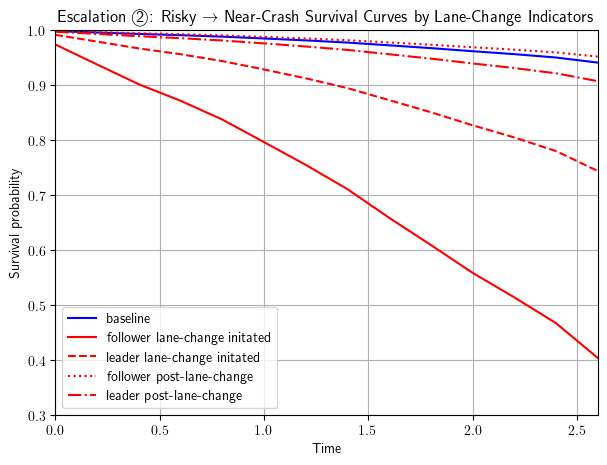

In [130]:
# Create a baseline row: all covariates set to 0
baseline = pd.DataFrame(0, index=[0], columns=surv1.columns)

# Keep duration and event out (not used as covariates)
baseline = baseline.drop(columns=['duration', 'event'], errors='ignore')

# Case 0: ego_pre_lc = 0
case0 = baseline.copy()

# Case 1: ego_pre_lc = 1
case1 = baseline.copy()
case1['ego_pre_lc'] = 1

# Case 2: foe_pre_lc = 1
case2 = baseline.copy()
case2['foe_pre_lc'] = 1

# Case 2: foe_pre_lc = 1
case3 = baseline.copy()
case3['ego_pos_lc'] = 1

# Case 2: foe_pre_lc = 1
case4 = baseline.copy()
case4['foe_pos_lc'] = 1

# Predict survival functions
sf0 = cph_cs1.predict_survival_function(case0)
sf1 = cph_cs1.predict_survival_function(case1)
sf2 = cph_cs1.predict_survival_function(case2)
sf3 = cph_cs1.predict_survival_function(case3)
sf4 = cph_cs1.predict_survival_function(case4)

time = (sf0.index-1)*0.2
# Plot
plt.figure(figsize=(7,5))
plt.plot(time, sf0.iloc[:,0], label="baseline", color="blue")
plt.plot(time, sf1.iloc[:,0], label="follower lane-change initated", color="red")
plt.plot(time, sf2.iloc[:,0], label="leader lane-change initated", color="red", linestyle='dashed')
plt.plot(time, sf3.iloc[:,0], label="follower post-lane-change", color="red", linestyle='dotted')
plt.plot(time, sf4.iloc[:,0], label="leader post-lane-change", color="red", linestyle='-.')


plt.title(r"Escalation \textcircled{2}: Risky $\rightarrow$ Near-Crash Survival Curves by Lane-Change Indicators")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.legend()
plt.grid(True)
plt.xlim(0, 13*0.2)
plt.ylim(0.3, 1)
plt.show()


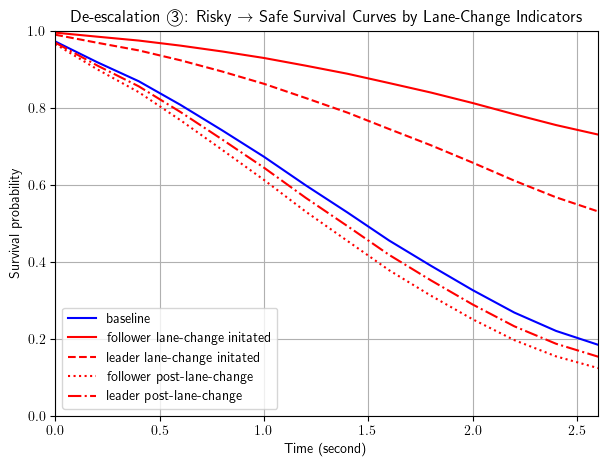

In [126]:
# Create a baseline row: all covariates set to 0
baseline = pd.DataFrame(0, index=[0], columns=surv2.columns)

# Keep duration and event out (not used as covariates)
baseline = baseline.drop(columns=['duration', 'event'], errors='ignore')

# Case 0: ego_pre_lc = 0
case0 = baseline.copy()

# Case 1: ego_pre_lc = 1
case1 = baseline.copy()
case1['ego_pre_lc'] = 1

# Case 2: foe_pre_lc = 1
case2 = baseline.copy()
case2['foe_pre_lc'] = 1

# Case 2: foe_pre_lc = 1
case3 = baseline.copy()
case3['ego_pos_lc'] = 1

# Case 2: foe_pre_lc = 1
case4 = baseline.copy()
case4['foe_pos_lc'] = 1

# Predict survival functions
sf0 = cph_cs2.predict_survival_function(case0)
sf1 = cph_cs2.predict_survival_function(case1)
sf2 = cph_cs2.predict_survival_function(case2)
sf3 = cph_cs2.predict_survival_function(case3)
sf4 = cph_cs2.predict_survival_function(case4)
time = (sf0.index-1)*0.2
# Plot
plt.figure(figsize=(7,5))
plt.plot(time, sf0.iloc[:,0], label="baseline", color="blue")
plt.plot(time, sf1.iloc[:,0], label="follower lane-change initated", color="red")
plt.plot(time, sf2.iloc[:,0], label="leader lane-change initated", color="red", linestyle='dashed')
plt.plot(time, sf3.iloc[:,0], label="follower post-lane-change", color="red", linestyle='dotted')
plt.plot(time, sf4.iloc[:,0], label="leader post-lane-change", color="red", linestyle='-.')


plt.title(r"De-escalation \textcircled{3}: Risky $\rightarrow$ Safe Survival Curves by Lane-Change Indicators")
plt.xlabel("Time (second)")
plt.ylabel("Survival probability")
plt.legend()
plt.grid(True)
plt.xlim(0, 13*0.2)
plt.ylim(0, 1)
plt.show()

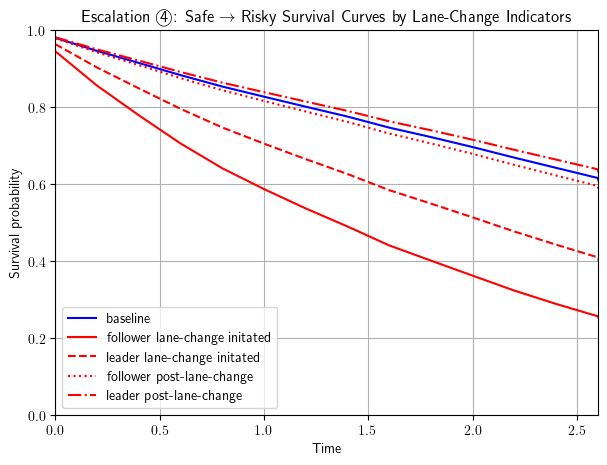

In [128]:
# Create a baseline row: all covariates set to 0
baseline = pd.DataFrame(0, index=[0], columns=surv3.columns)

# Keep duration and event out (not used as covariates)
baseline = baseline.drop(columns=['duration', 'event'], errors='ignore')

# Case 0: ego_pre_lc = 0
case0 = baseline.copy()

# Case 1: ego_pre_lc = 1
case1 = baseline.copy()
case1['ego_pre_lc'] = 1

# Case 2: foe_pre_lc = 1
case2 = baseline.copy()
case2['foe_pre_lc'] = 1

# Case 2: foe_pre_lc = 1
case3 = baseline.copy()
case3['ego_pos_lc'] = 1

# Case 2: foe_pre_lc = 1
case4 = baseline.copy()
case4['foe_pos_lc'] = 1

# Predict survival functions
sf0 = cph_cs3.predict_survival_function(case0)
sf1 = cph_cs3.predict_survival_function(case1)
sf2 = cph_cs3.predict_survival_function(case2)
sf3 = cph_cs3.predict_survival_function(case3)
sf4 = cph_cs3.predict_survival_function(case4)
time = (sf0.index-1)*0.2
# Plot
plt.figure(figsize=(7,5))
plt.plot(time, sf0.iloc[:,0], label="baseline", color="blue")
plt.plot(time, sf1.iloc[:,0], label="follower lane-change initated", color="red")
plt.plot(time, sf2.iloc[:,0], label="leader lane-change initated", color="red", linestyle='dashed')
plt.plot(time, sf3.iloc[:,0], label="follower post-lane-change", color="red", linestyle='dotted')
plt.plot(time, sf4.iloc[:,0], label="leader post-lane-change", color="red", linestyle='-.')


plt.title(r"Escalation \textcircled{4}: Safe $\rightarrow$ Risky Survival Curves by Lane-Change Indicators")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.legend()
plt.grid(True)
plt.xlim(0, 13*0.2)
plt.ylim(0, 1)
plt.show()

### Cox-PH (CIF)

In [73]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.4.1"
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, numpy2ri
import cmprsk

In [74]:
# Activate automatic conversion between pandas DataFrames and R data.frames
numpy2ri.activate()
pandas2ri.activate()

In [84]:
esc_mask = (input[:,-2]==2)&(input[:,-1]==1)
esc_duration = input[esc_mask][:,-3]/5
esc_input = input[esc_mask][:,:12]
esc_label = np.full(len(esc_input), 1)

desc_mask = (input[:,-2]==2)&(input[:,-1]==3)
desc_duration = input[desc_mask][:,-3]/5
desc_input = input[desc_mask][:,:12]
desc_label = np.full(len(desc_input), 2)

censor_mask = (input[:,-2]==2)&(input[:,-1]==2)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:12]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([esc_duration, desc_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([esc_label, desc_label, censor_label])
_covariate = torch.concatenate([esc_input, desc_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

event1 = event
event2 = np.where(event == 1, 2, np.where(event == 2, 1, event))

covariate_names = ['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class', 'local_density', 'local_speed','ramp','congestion']
sl_covariates = ['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel','ego_class', 'foe_class', 'ramp','congestion']
DATA = pd.DataFrame(data=covariate, columns=covariate_names)
DATA['duration'] = duration
DATA['event1'] = event1
DATA['event2'] = event2
# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data"] = pandas2ri.py2rpy(DATA)

Transition risky-->near-crash

In [86]:
# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data[, c('ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel','ego_class', 'foe_class', 'ramp','congestion')])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model <- crr(ftime = data$duration, fstatus = data$event1, cov1 = covariates)

# Output the summary of the model
summary(fg_model)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary = robjects.r("summary(fg_model)")
# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix = np.array(fg_summary.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary = pd.DataFrame(
    {"covariate_name": sel_columns, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)
print (result_summary)

Shape of fg_coef_matrix: (10, 5)
Log-test information (model fitness): [1348.96827276   10.        ]
Model Convergence: True
  covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0     ego_pre_lc     20.231442    15.478688    26.443535  0.000000e+00
1     foe_pre_lc     11.806769     6.231451    22.370360  3.700000e-14
2     ego_pos_lc      0.398553     0.226579     0.701054  1.400000e-03
3     foe_pos_lc      1.702340     1.135562     2.552006  1.000000e-02
4      ego_accel      1.047439     0.879466     1.247494  6.000000e-01
5      foe_accel      0.164480     0.026960     1.003476  5.000000e-02
6      ego_class      0.384132     0.265392     0.555998  4.000000e-07
7      foe_class      3.193712     2.742298     3.719435  0.000000e+00
8           ramp      3.057753     2.207175     4.236119  1.800000e-11
9     congestion      0.158606     0.117949     0.213277  0.000000e+00


In [87]:
# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data[, c('ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel','ego_class', 'foe_class','ramp','congestion')])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model <- crr(ftime = data$duration, fstatus = data$event2, cov1 = covariates)

# Output the summary of the model
summary(fg_model)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary = robjects.r("summary(fg_model)")
# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix = np.array(fg_summary.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary = pd.DataFrame(
    {"covariate_name": sel_columns, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)
print (result_summary)

Shape of fg_coef_matrix: (10, 5)
Log-test information (model fitness): [653.42695164  10.        ]
Model Convergence: True
  covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0     ego_pre_lc      0.147317     0.098113     0.221195  0.000000e+00
1     foe_pre_lc      0.240218     0.111027     0.519736  2.900000e-04
2     ego_pos_lc      1.548806     1.321611     1.815058  6.500000e-08
3     foe_pos_lc      1.118379     0.861013     1.452675  4.000000e-01
4      ego_accel      0.898323     0.844051     0.956085  7.500000e-04
5      foe_accel      1.298410     0.978071     1.723667  7.100000e-02
6      ego_class      1.385309     1.237434     1.550855  1.500000e-08
7      foe_class      0.566734     0.518767     0.619138  0.000000e+00
8           ramp      0.345175     0.233528     0.510200  9.500000e-08
9     congestion      1.288367     1.226322     1.353552  0.000000e+00


Get transition safe->risky

In [143]:
risk_mask = (input[:,-2]==3)&(input[:,-1]==2)
risk_duration = input[risk_mask][:,-3]/5
risk_input = input[risk_mask][:,:11]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input[:,-2]==3)&(input[:,-1]==3)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:11]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([risk_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([risk_label, censor_label])
_covariate = torch.concatenate([risk_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

covariate_names = ['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class', 'local_density', 'local_speed','ramp']
DATA = pd.DataFrame(data=covariate, columns=covariate_names)
DATA['duration'] = duration
DATA['event'] = event

# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data_4"] = pandas2ri.py2rpy(DATA)

# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data_4[, c('ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel','ego_class', 'foe_class', 'local_density', 'local_speed','ramp')])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model_4 <- crr(ftime = data_4$duration, fstatus = data_4$event, cov1 = covariates)

# Output the summary of the model
summary(fg_model_4)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary_4 = robjects.r("summary(fg_model_4)")

# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix_4 = np.array(fg_summary_4.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix_4[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix_4[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix_4[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix_4[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary_4.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary_4.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary_4.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary_4.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary_4 = pd.DataFrame(
    {"covariate_name": covariate_names, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)


print (result_summary_4)



Shape of fg_coef_matrix: (11, 5)
Log-test information (model fitness): [2312.90858484   11.        ]
Model Convergence: True
   covariate_name  hazard_ratio  lower_bound  upper_bound  p_values
0      ego_pre_lc      2.730552     2.594687     2.873531  0.000000
1      foe_pre_lc      1.840255     1.725243     1.962934  0.000000
2      ego_pos_lc      1.071050     1.013551     1.131811  0.015000
3      foe_pos_lc      0.962807     0.908371     1.020505  0.200000
4       ego_accel      1.482625     1.426174     1.541309  0.000000
5       foe_accel      0.701838     0.672386     0.732581  0.000000
6       ego_class      1.039138     0.981317     1.100366  0.190000
7       foe_class      0.938503     0.909758     0.968156  0.000064
8   local_density      1.008761     0.998024     1.019614  0.110000
9     local_speed      0.984389     0.971644     0.997302  0.018000
10           ramp      1.058025     0.946573     1.182599  0.320000


AFT -- Cause-specific

In [179]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, GeneralizedGammaRegressionFitter, LogLogisticAFTFitter

Get transition safe->risky AFT

In [200]:
risk_mask = (input[:,-2]==3)&(input[:,-1]==2)
risk_duration = input[risk_mask][:,-3]/5
risk_input = input[risk_mask][:,:11]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input[:,-2]==3)&(input[:,-1]==3)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:11]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([risk_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([risk_label, censor_label])
_covariate = torch.concatenate([risk_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

# create the survival dataframe
surv3 = pd.DataFrame(data=covariate, columns=covariate_names)
surv3['duration'] = duration
surv3['event'] = np.asarray(event == 1).astype(int)

In [201]:
aft = LogNormalAFTFitter()
aft.fit(surv3, duration_col='duration', event_col='event', formula=" + ".join(covariate_names))
print("Log-Normal AFT Model Summary:")
aft.print_summary()

aft = WeibullAFTFitter()
aft.fit(surv3, duration_col='duration', event_col='event', formula=" + ".join(covariate_names))
print("Weibull AFT Model Summary:")
aft.print_summary()

aft = LogLogisticAFTFitter()
aft.fit(surv3, duration_col='duration', event_col='event', formula=" + ".join(covariate_names))
print("Log-Logistic AFT Model Summary:")
aft.print_summary()

# aft = GeneralizedGammaRegressionFitter()
# aft.fit(surv3, duration_col='duration', event_col='event')
# print("Generalized-Gamma AFT Model Summary:")
# aft.print_summary()

Log-Normal AFT Model Summary:


<lifelines.LogNormalAFTFitter: fitted with 20439 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
   number of observations = 20439
number of events observed = 20439
           log-likelihood = -65990.56
         time fit was run = 2025-04-10 23:34:43 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
mu_    Intercept      2.34     10.42      0.05            2.25            2.43                9.53               11.40
       ego_pre_lc    -0.65      0.52      0.01           -0.68           -0.63                0.51                0.54
       foe_pre_lc    -0.43      0.65      0.02           -0.47           -0.40                0.63                0.67
       ego_pos_lc    -0.05      0.95      0.02           -0.09           -0.00                0.91                1.00
       foe_pos_lc     0.01      1.01      0.03           -0.05            0.06                0.96                1.06
       ego_accel     -0.43      0.65      0.01           -0.46           -0.40                0.63                0.67
       foe_accel      0.46      1.58      0.01            0.43            0.49                1.53                1.63
       ego_class     -0.03      0.97      0.02           -0.08            0.01                0.92                1.01
       foe_class      0.06      1.06      0.01            0.03            0.08                1.03                1.09
       local_density -0.01      0.99      0.00           -0.02           -0.00                0.98                1.00
       local_speed    0.02      1.02      0.01            0.00            0.03                1.00                1.03
       ramp          -0.05      0.95      0.05           -0.14            0.04                0.87                1.04
sigma_ Intercept     -0.46      0.63      0.00           -0.47           -0.45                0.63                0.64

                      cmp to      z      p  -log2(p)
param  covariate                                    
mu_    Intercept        0.00  51.30 <0.005       inf
       ego_pre_lc       0.00 -47.01 <0.005       inf
       foe_pre_lc       0.00 -22.93 <0.005    384.04
       ego_pos_lc       0.00  -1.98   0.05      4.39
       foe_pos_lc       0.00   0.23   0.82      0.29
       ego_accel        0.00 -30.31 <0.005    668.09
       foe_accel        0.00  30.72 <0.005    686.18
       ego_class        0.00  -1.38   0.17      2.59
       foe_class        0.00   4.27 <0.005     15.63
       local_density    0.00  -2.12   0.03      4.87
       local_speed      0.00   2.59   0.01      6.72
       ramp             0.00  -1.07   0.28      1.82
sigma_ Intercept        0.00 -92.35 <0.005       inf
---
Concordance = 0.68
AIC = 132007.13
log-likelihood ratio test = 3579.74 on 11 df
-log2(p) of ll-ratio test = inf

Weibull AFT Model Summary:


<lifelines.WeibullAFTFitter: fitted with 20439 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
   number of observations = 20439
number of events observed = 20439
           log-likelihood = -60919.04
         time fit was run = 2025-04-10 23:34:44 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                      
lambda_ Intercept      2.57     13.06      0.03            2.52            2.62               12.38               13.77
        ego_pre_lc    -0.35      0.71      0.01           -0.36           -0.33                0.70                0.72
        foe_pre_lc    -0.21      0.81      0.01           -0.23           -0.19                0.79                0.83
        ego_pos_lc    -0.02      0.98      0.01           -0.05            0.00                0.95                1.00
        foe_pos_lc     0.01      1.01      0.02           -0.03            0.04                0.97                1.04
        ego_accel     -0.16      0.85      0.01           -0.18           -0.14                0.84                0.87
        foe_accel      0.15      1.16      0.01            0.13            0.17                1.14                1.19
        ego_class     -0.02      0.98      0.01           -0.05            0.01                0.95                1.01
        foe_class      0.02      1.02      0.01            0.01            0.04                1.01                1.04
        local_density -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
        local_speed    0.01      1.01      0.00           -0.00            0.01                1.00                1.01
        ramp          -0.01      0.99      0.03           -0.07            0.04                0.94                1.04
rho_    Intercept      0.98      2.67      0.01            0.97            0.99                2.64                2.70

                       cmp to      z      p  -log2(p)
param   covariate                                    
lambda_ Intercept        0.00  94.52 <0.005       inf
        ego_pre_lc       0.00 -42.18 <0.005       inf
        foe_pre_lc       0.00 -19.02 <0.005    265.60
        ego_pos_lc       0.00  -1.64   0.10      3.30
        foe_pos_lc       0.00   0.33   0.74      0.43
        ego_accel        0.00 -18.15 <0.005    242.14
        foe_accel        0.00  15.92 <0.005    187.20
        ego_class        0.00  -1.44   0.15      2.73
        foe_class        0.00   2.75   0.01      7.38
        local_density    0.00  -1.16   0.25      2.02
        local_speed      0.00   1.63   0.10      3.28
        ramp             0.00  -0.44   0.66      0.60
rho_    Intercept        0.00 156.09 <0.005       inf
---
Concordance = 0.68
AIC = 121864.07
log-likelihood ratio test = 2146.27 on 11 df
-log2(p) of ll-ratio test = inf

Log-Logistic AFT Model Summary:


<lifelines.LogLogisticAFTFitter: fitted with 20439 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
   number of observations = 20439
number of events observed = 20439
           log-likelihood = -64731.77
         time fit was run = 2025-04-10 23:34:44 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
alpha_ Intercept      2.46     11.68      0.04            2.38            2.53               10.83               12.61
       ego_pre_lc    -0.67      0.51      0.01           -0.69           -0.64                0.50                0.53
       foe_pre_lc    -0.43      0.65      0.02           -0.46           -0.39                0.63                0.68
       ego_pos_lc    -0.04      0.96      0.02           -0.08            0.00                0.92                1.00
       foe_pos_lc    -0.01      0.99      0.02           -0.05            0.04                0.95                1.04
       ego_accel     -0.34      0.71      0.01           -0.36           -0.31                0.70                0.73
       foe_accel      0.34      1.40      0.01            0.31            0.36                1.36                1.44
       ego_class     -0.04      0.96      0.02           -0.08           -0.00                0.92                1.00
       foe_class      0.05      1.05      0.01            0.03            0.07                1.03                1.08
       local_density -0.01      0.99      0.00           -0.02           -0.00                0.98                1.00
       local_speed    0.01      1.01      0.00            0.00            0.02                1.00                1.02
       ramp          -0.03      0.97      0.04           -0.11            0.04                0.89                1.04
beta_  Intercept      1.14      3.13      0.01            1.13            1.15                3.10                3.17

                      cmp to      z      p  -log2(p)
param  covariate                                    
alpha_ Intercept        0.00  63.32 <0.005       inf
       ego_pre_lc       0.00 -49.81 <0.005       inf
       foe_pre_lc       0.00 -23.79 <0.005    413.00
       ego_pos_lc       0.00  -1.83   0.07      3.90
       foe_pos_lc       0.00  -0.34   0.74      0.44
       ego_accel        0.00 -26.90 <0.005    526.92
       foe_accel        0.00  24.63 <0.005    442.61
       ego_class        0.00  -1.98   0.05      4.37
       foe_class        0.00   4.54 <0.005     17.43
       local_density    0.00  -2.03   0.04      4.57
       local_speed      0.00   2.49   0.01      6.28
       ramp             0.00  -0.87   0.38      1.38
beta_  Intercept        0.00 186.12 <0.005       inf
---
Concordance = 0.68
AIC = 129489.54
log-likelihood ratio test = 3750.44 on 11 df
-log2(p) of ll-ratio test = inf

Get transition risky->near-miss AFT Escalation

In [187]:
esc_mask = (input[:,-2]==2)&(input[:,-1]==1)
esc_duration = input[esc_mask][:,-3]/5
esc_input = input[esc_mask][:,:11]
esc_label = np.full(len(esc_input), 1)

desc_mask = (input[:,-2]==2)&(input[:,-1]==3)
desc_duration = input[desc_mask][:,-3]/5
desc_input = input[desc_mask][:,:11]
desc_label = np.full(len(desc_input), 2)

censor_mask = (input[:,-2]==2)&(input[:,-1]==2)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:11]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([esc_duration, desc_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([esc_label, desc_label, censor_label])
_covariate = torch.concatenate([esc_input, desc_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

In [199]:
# create the survival dataframe
surv1 = pd.DataFrame(data=covariate, columns=covariate_names)
surv1['duration'] = duration
surv1['event_cause1'] = np.asarray(event == 1).astype(int)

aft = LogNormalAFTFitter()
aft.fit(surv1, duration_col='duration', event_col='event_cause1', formula=" + ".join(covariate_names))
print("Log-Normal AFT Model Summary:")
aft.print_summary()

aft = WeibullAFTFitter()
aft.fit(surv1, duration_col='duration', event_col='event_cause1', formula=" + ".join(covariate_names))
print("Weibull AFT Model Summary:")
aft.print_summary()

aft = LogLogisticAFTFitter()
aft.fit(surv1, duration_col='duration', event_col='event_cause1', formula=" + ".join(covariate_names))
print("Log-Logistic AFT Model Summary:")
aft.print_summary()


Log-Normal AFT Model Summary:


<lifelines.LogNormalAFTFitter: fitted with 9921 total observations, 8709 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
   number of observations = 9921
number of events observed = 1212
           log-likelihood = -4796.58
         time fit was run = 2025-04-10 23:34:06 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
mu_    Intercept      4.25     69.86      0.22            3.81            4.68               45.13              108.12
       ego_pre_lc    -1.70      0.18      0.06           -1.81           -1.59                0.16                0.20
       foe_pre_lc    -1.40      0.25      0.08           -1.55           -1.25                0.21                0.29
       ego_pos_lc     0.04      1.04      0.11           -0.18            0.25                0.84                1.28
       foe_pos_lc    -0.30      0.74      0.12           -0.54           -0.07                0.59                0.93
       ego_accel     -0.18      0.83      0.05           -0.29           -0.07                0.75                0.93
       foe_accel     -0.33      0.72      0.07           -0.47           -0.19                0.62                0.83
       ego_class     -0.10      0.90      0.10           -0.30            0.09                0.74                1.10
       foe_class     -0.14      0.87      0.05           -0.24           -0.03                0.79                0.97
       local_density  0.07      1.07      0.02            0.02            0.12                1.02                1.12
       local_speed   -0.05      0.95      0.03           -0.10            0.01                0.90                1.01
       ramp           0.14      1.15      0.14           -0.14            0.43                0.87                1.53
sigma_ Intercept     -0.05      0.95      0.02           -0.10           -0.01                0.91                0.99

                      cmp to      z      p  -log2(p)
param  covariate                                    
mu_    Intercept        0.00  19.05 <0.005    266.43
       ego_pre_lc       0.00 -29.85 <0.005    648.08
       foe_pre_lc       0.00 -18.32 <0.005    246.54
       ego_pos_lc       0.00   0.34   0.73      0.45
       foe_pos_lc       0.00  -2.54   0.01      6.49
       ego_accel        0.00  -3.32 <0.005     10.14
       foe_accel        0.00  -4.61 <0.005     17.95
       ego_class        0.00  -1.03   0.30      1.72
       foe_class        0.00  -2.60   0.01      6.76
       local_density    0.00   2.79   0.01      7.58
       local_speed      0.00  -1.64   0.10      3.31
       ramp             0.00   1.00   0.32      1.66
sigma_ Intercept        0.00  -2.50   0.01      6.34
---
Concordance = 0.89
AIC = 9619.17
log-likelihood ratio test = 2870.67 on 11 df
-log2(p) of ll-ratio test = inf

Weibull AFT Model Summary:


<lifelines.WeibullAFTFitter: fitted with 9921 total observations, 8709 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
   number of observations = 9921
number of events observed = 1212
           log-likelihood = -4821.90
         time fit was run = 2025-04-10 23:34:07 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                      
lambda_ Intercept      4.24     69.23      0.21            3.84            4.64               46.32              103.48
        ego_pre_lc    -1.45      0.23      0.06           -1.57           -1.34                0.21                0.26
        foe_pre_lc    -0.92      0.40      0.06           -1.03           -0.81                0.36                0.44
        ego_pos_lc     0.07      1.07      0.09           -0.11            0.24                0.90                1.28
        foe_pos_lc    -0.24      0.79      0.09           -0.41           -0.06                0.66                0.94
        ego_accel     -0.09      0.92      0.05           -0.19            0.01                0.83                1.01
        foe_accel     -0.41      0.66      0.08           -0.56           -0.26                0.57                0.77
        ego_class      0.01      1.01      0.09           -0.17            0.18                0.85                1.20
        foe_class     -0.07      0.94      0.04           -0.15            0.01                0.86                1.01
        local_density  0.09      1.10      0.02            0.05            0.14                1.05                1.15
        local_speed   -0.06      0.94      0.03           -0.11           -0.01                0.90                0.99
        ramp           0.04      1.04      0.10           -0.16            0.24                0.85                1.27
rho_    Intercept      0.53      1.71      0.02            0.49            0.58                1.63                1.79

                       cmp to      z      p  -log2(p)
param   covariate                                    
lambda_ Intercept        0.00  20.66 <0.005    312.70
        ego_pre_lc       0.00 -23.96 <0.005    419.05
        foe_pre_lc       0.00 -16.58 <0.005    202.70
        ego_pos_lc       0.00   0.77   0.44      1.18
        foe_pos_lc       0.00  -2.64   0.01      6.91
        ego_accel        0.00  -1.70   0.09      3.50
        foe_accel        0.00  -5.33 <0.005     23.30
        ego_class        0.00   0.10   0.92      0.12
        foe_class        0.00  -1.65   0.10      3.32
        local_density    0.00   4.23 <0.005     15.37
        local_speed      0.00  -2.21   0.03      5.21
        ramp             0.00   0.37   0.71      0.50
rho_    Intercept        0.00  21.69 <0.005    344.24
---
Concordance = 0.89
AIC = 9669.81
log-likelihood ratio test = 2683.07 on 11 df
-log2(p) of ll-ratio test = inf

Log-Logistic AFT Model Summary:


<lifelines.LogLogisticAFTFitter: fitted with 9921 total observations, 8709 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
   number of observations = 9921
number of events observed = 1212
           log-likelihood = -4764.12
         time fit was run = 2025-04-10 23:34:07 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
alpha_ Intercept      4.06     58.16      0.22            3.63            4.50               37.73               89.67
       ego_pre_lc    -1.64      0.19      0.06           -1.76           -1.51                0.17                0.22
       foe_pre_lc    -1.40      0.25      0.08           -1.56           -1.25                0.21                0.29
       ego_pos_lc     0.04      1.04      0.10           -0.16            0.24                0.85                1.28
       foe_pos_lc    -0.29      0.75      0.11           -0.51           -0.07                0.60                0.93
       ego_accel     -0.17      0.84      0.06           -0.28           -0.06                0.76                0.94
       foe_accel     -0.34      0.71      0.07           -0.49           -0.19                0.61                0.82
       ego_class     -0.04      0.96      0.10           -0.24            0.16                0.79                1.18
       foe_class     -0.11      0.90      0.05           -0.20           -0.01                0.82                0.99
       local_density  0.08      1.09      0.02            0.04            0.13                1.04                1.14
       local_speed   -0.04      0.97      0.03           -0.09            0.02                0.91                1.02
       ramp           0.13      1.14      0.12           -0.11            0.38                0.90                1.46
beta_  Intercept      0.72      2.04      0.02            0.67            0.76                1.95                2.14

                      cmp to      z      p  -log2(p)
param  covariate                                    
alpha_ Intercept        0.00  18.40 <0.005    248.66
       ego_pre_lc       0.00 -25.89 <0.005    488.36
       foe_pre_lc       0.00 -17.99 <0.005    237.99
       ego_pos_lc       0.00   0.42   0.68      0.57
       foe_pos_lc       0.00  -2.61   0.01      6.78
       ego_accel        0.00  -3.04 <0.005      8.74
       foe_accel        0.00  -4.56 <0.005     17.59
       ego_class        0.00  -0.37   0.71      0.49
       foe_class        0.00  -2.20   0.03      5.16
       local_density    0.00   3.46 <0.005     10.84
       local_speed      0.00  -1.27   0.21      2.28
       ramp             0.00   1.08   0.28      1.84
beta_  Intercept        0.00  29.57 <0.005    635.95
---
Concordance = 0.89
AIC = 9554.23
log-likelihood ratio test = 2825.99 on 11 df
-log2(p) of ll-ratio test = inf

In [198]:
# create the survival dataframe

surv2 = pd.DataFrame(data=covariate, columns=covariate_names)
surv2['duration'] = duration
surv2['event_cause2'] = np.asarray(event == 2).astype(int)

aft = LogNormalAFTFitter()
aft.fit(surv2, duration_col='duration', event_col='event_cause2', formula=" + ".join(covariate_names))
print("Log-Normal AFT Model Summary:")
aft.print_summary()

aft = WeibullAFTFitter()
aft.fit(surv2, duration_col='duration', event_col='event_cause2', formula=" + ".join(covariate_names))
print("Weibull AFT Model Summary:")
aft.print_summary()

aft = LogLogisticAFTFitter()
aft.fit(surv2, duration_col='duration', event_col='event_cause2', formula=" + ".join(covariate_names))
print("Log-Logistic AFT Model Summary:")
aft.print_summary()


Log-Normal AFT Model Summary:


<lifelines.LogNormalAFTFitter: fitted with 9921 total observations, 2561 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause2'
   number of observations = 9921
number of events observed = 7360
           log-likelihood = -23734.32
         time fit was run = 2025-04-10 23:33:42 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
mu_    Intercept      2.04      7.72      0.07            1.91            2.18                6.73                8.86
       ego_pre_lc     0.82      2.28      0.03            0.77            0.88                2.15                2.41
       foe_pre_lc     0.34      1.41      0.06            0.23            0.45                1.26                1.57
       ego_pos_lc    -0.24      0.79      0.04           -0.32           -0.16                0.73                0.85
       foe_pos_lc    -0.13      0.87      0.06           -0.25           -0.02                0.78                0.98
       ego_accel      0.36      1.43      0.02            0.32            0.39                1.38                1.48
       foe_accel     -0.11      0.89      0.02           -0.15           -0.08                0.86                0.93
       ego_class     -0.26      0.77      0.04           -0.33           -0.19                0.72                0.83
       foe_class      0.12      1.13      0.03            0.07            0.18                1.07                1.20
       local_density -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
       local_speed    0.00      1.00      0.01           -0.02            0.02                0.98                1.02
       ramp           0.41      1.50      0.11            0.19            0.63                1.20                1.87
sigma_ Intercept     -0.31      0.74      0.01           -0.32           -0.29                0.72                0.75

                      cmp to      z      p  -log2(p)
param  covariate                                    
mu_    Intercept        0.00  29.04 <0.005    613.57
       ego_pre_lc       0.00  28.12 <0.005    575.52
       foe_pre_lc       0.00   6.08 <0.005     29.65
       ego_pos_lc       0.00  -5.85 <0.005     27.61
       foe_pos_lc       0.00  -2.25   0.02      5.36
       ego_accel        0.00  18.76 <0.005    258.30
       foe_accel        0.00  -5.91 <0.005     28.17
       ego_class        0.00  -6.95 <0.005     38.01
       foe_class        0.00   4.17 <0.005     15.00
       local_density    0.00  -0.96   0.34      1.57
       local_speed      0.00   0.23   0.81      0.30
       ramp             0.00   3.61 <0.005     11.65
sigma_ Intercept        0.00 -35.92 <0.005    936.17
---
Concordance = 0.63
AIC = 47494.65
log-likelihood ratio test = 1524.83 on 11 df
-log2(p) of ll-ratio test = inf

Weibull AFT Model Summary:


<lifelines.WeibullAFTFitter: fitted with 9921 total observations, 2561 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause2'
   number of observations = 9921
number of events observed = 7360
           log-likelihood = -23270.97
         time fit was run = 2025-04-10 23:33:42 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                      
lambda_ Intercept      2.32     10.22      0.06            2.22            2.43                9.17               11.38
        ego_pre_lc     0.89      2.44      0.03            0.83            0.96                2.28                2.60
        foe_pre_lc     0.51      1.66      0.06            0.39            0.62                1.47                1.87
        ego_pos_lc    -0.13      0.88      0.03           -0.19           -0.07                0.82                0.94
        foe_pos_lc    -0.05      0.95      0.05           -0.14            0.05                0.87                1.05
        ego_accel      0.23      1.26      0.02            0.20            0.26                1.22                1.30
        foe_accel     -0.06      0.94      0.01           -0.09           -0.03                0.92                0.97
        ego_class     -0.10      0.90      0.03           -0.16           -0.05                0.85                0.96
        foe_class      0.09      1.10      0.02            0.04            0.14                1.05                1.15
        local_density -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
        local_speed    0.00      1.00      0.01           -0.01            0.01                0.99                1.01
        ramp           0.33      1.40      0.11            0.12            0.54                1.13                1.72
rho_    Intercept      0.63      1.87      0.01            0.61            0.65                1.84                1.91

                       cmp to     z      p  -log2(p)
param   covariate                                   
lambda_ Intercept        0.00 42.17 <0.005       inf
        ego_pre_lc       0.00 26.66 <0.005    517.68
        foe_pre_lc       0.00  8.38 <0.005     54.11
        ego_pos_lc       0.00 -4.04 <0.005     14.21
        foe_pos_lc       0.00 -0.94   0.35      1.53
        ego_accel        0.00 13.73 <0.005    140.03
        foe_accel        0.00 -4.00 <0.005     13.93
        ego_class        0.00 -3.51 <0.005     11.12
        foe_class        0.00  3.74 <0.005     12.39
        local_density    0.00 -0.80   0.42      1.23
        local_speed      0.00  0.02   0.99      0.02
        ramp             0.00  3.09 <0.005      8.98
rho_    Intercept        0.00 63.80 <0.005       inf
---
Concordance = 0.63
AIC = 46567.94
log-likelihood ratio test = 1740.38 on 11 df
-log2(p) of ll-ratio test = inf

Log-Logistic AFT Model Summary:


<lifelines.LogLogisticAFTFitter: fitted with 9921 total observations, 2561 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause2'
   number of observations = 9921
number of events observed = 7360
           log-likelihood = -23571.28
         time fit was run = 2025-04-10 23:33:42 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
alpha_ Intercept      2.06      7.82      0.07            1.93            2.19                6.86                8.91
       ego_pre_lc     0.87      2.39      0.03            0.81            0.93                2.25                2.54
       foe_pre_lc     0.44      1.55      0.06            0.32            0.56                1.38                1.75
       ego_pos_lc    -0.21      0.81      0.04           -0.29           -0.13                0.75                0.88
       foe_pos_lc    -0.15      0.86      0.06           -0.27           -0.04                0.76                0.96
       ego_accel      0.30      1.35      0.02            0.26            0.33                1.30                1.40
       foe_accel     -0.09      0.91      0.02           -0.12           -0.05                0.88                0.95
       ego_class     -0.23      0.79      0.04           -0.31           -0.16                0.73                0.85
       foe_class      0.11      1.12      0.03            0.05            0.17                1.05                1.18
       local_density -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
       local_speed    0.00      1.00      0.01           -0.01            0.02                0.99                1.02
       ramp           0.39      1.48      0.11            0.17            0.60                1.19                1.83
beta_  Intercept      0.90      2.46      0.01            0.88            0.92                2.41                2.50

                      cmp to     z      p  -log2(p)
param  covariate                                   
alpha_ Intercept        0.00 30.91 <0.005    694.61
       ego_pre_lc       0.00 28.44 <0.005    588.66
       foe_pre_lc       0.00  7.31 <0.005     41.73
       ego_pos_lc       0.00 -5.20 <0.005     22.24
       foe_pos_lc       0.00 -2.55   0.01      6.55
       ego_accel        0.00 16.15 <0.005    192.53
       foe_accel        0.00 -4.98 <0.005     20.58
       ego_class        0.00 -6.23 <0.005     31.00
       foe_class        0.00  3.76 <0.005     12.50
       local_density    0.00 -0.31   0.76      0.40
       local_speed      0.00  0.51   0.61      0.71
       ramp             0.00  3.54 <0.005     11.26
beta_  Intercept        0.00 91.37 <0.005       inf
---
Concordance = 0.63
AIC = 47168.55
log-likelihood ratio test = 1548.33 on 11 df
-log2(p) of ll-ratio test = inf

In [195]:
esc_mask = (input[:,-2]==2)&(input[:,-1]==1)
esc_duration = input[esc_mask][:,-3]/5
esc_input = input[esc_mask][:,:11]
esc_label = np.full(len(esc_input), 1)

desc_mask = (input[:,-2]==2)&(input[:,-1]==3)
desc_duration = input[desc_mask][:,-3]/5
desc_input = input[desc_mask][:,:11]
desc_label = np.full(len(desc_input), 2)

censor_mask = (input[:,-2]==2)&(input[:,-1]==2)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:11]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([esc_duration, desc_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([esc_label, desc_label, censor_label])
_covariate = torch.concatenate([esc_input, desc_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

#
covariate_names = ['ego_pre_lc', 'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_accel', 'foe_accel', 
                                             'ego_class', 'foe_class', 'local_density', 'local_speed', 'ramp']
# create the survival dataframe
surv = pd.DataFrame(data=covariate, columns=covariate_names)
surv['duration'] = duration
surv['event_cause1'] = np.asarray(event == 1).astype(int)
surv['event_cause2'] = np.asarray(event == 2).astype(int)


In [202]:
# Fit AFT model for cause 1 (event of interest)
aft_cause1 = LogNormalAFTFitter()
aft_cause1.fit(surv, duration_col='duration', event_col='event_cause1', formula=" + ".join(covariate_names))
print("\nCause 1 AFT model summary:")
aft_cause1.print_summary()

# Fit AFT model for cause 2 (competing event)
aft_cause2 = LogNormalAFTFitter()
aft_cause2.fit(surv, duration_col='duration', event_col='event_cause2', formula=" + ".join(covariate_names))
print("\nCause 2 AFT model summary:")
aft_cause2.print_summary()

# Fit AFT model for cause 1 (event of interest)
aft_cause1 = WeibullAFTFitter()
aft_cause1.fit(surv, duration_col='duration', event_col='event_cause1', formula=" + ".join(covariate_names))
print("\nCause 1 AFT model summary:")
aft_cause1.print_summary()

# Fit AFT model for cause 2 (competing event)
aft_cause2 = WeibullAFTFitter()
aft_cause2.fit(surv, duration_col='duration', event_col='event_cause2', formula=" + ".join(covariate_names))
print("\nCause 2 AFT model summary:")
aft_cause2.print_summary()

# Fit AFT model for cause 1 (event of interest)
aft_cause1 = LogLogisticAFTFitter()
aft_cause1.fit(surv, duration_col='duration', event_col='event_cause1', formula=" + ".join(covariate_names))
print("\nCause 1 AFT model summary:")
aft_cause1.print_summary()

# Fit AFT model for cause 2 (competing event)
aft_cause2 = LogLogisticAFTFitter()
aft_cause2.fit(surv, duration_col='duration', event_col='event_cause2', formula=" + ".join(covariate_names))
print("\nCause 2 AFT model summary:")
aft_cause2.print_summary()


Cause 1 AFT model summary:


<lifelines.LogNormalAFTFitter: fitted with 9921 total observations, 8709 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
   number of observations = 9921
number of events observed = 1212
           log-likelihood = -4796.58
         time fit was run = 2025-04-10 23:36:13 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
mu_    Intercept      4.25     69.86      0.22            3.81            4.68               45.13              108.12
       ego_pre_lc    -1.70      0.18      0.06           -1.81           -1.59                0.16                0.20
       foe_pre_lc    -1.40      0.25      0.08           -1.55           -1.25                0.21                0.29
       ego_pos_lc     0.04      1.04      0.11           -0.18            0.25                0.84                1.28
       foe_pos_lc    -0.30      0.74      0.12           -0.54           -0.07                0.59                0.93
       ego_accel     -0.18      0.83      0.05           -0.29           -0.07                0.75                0.93
       foe_accel     -0.33      0.72      0.07           -0.47           -0.19                0.62                0.83
       ego_class     -0.10      0.90      0.10           -0.30            0.09                0.74                1.10
       foe_class     -0.14      0.87      0.05           -0.24           -0.03                0.79                0.97
       local_density  0.07      1.07      0.02            0.02            0.12                1.02                1.12
       local_speed   -0.05      0.95      0.03           -0.10            0.01                0.90                1.01
       ramp           0.14      1.15      0.14           -0.14            0.43                0.87                1.53
sigma_ Intercept     -0.05      0.95      0.02           -0.10           -0.01                0.91                0.99

                      cmp to      z      p  -log2(p)
param  covariate                                    
mu_    Intercept        0.00  19.05 <0.005    266.43
       ego_pre_lc       0.00 -29.85 <0.005    648.08
       foe_pre_lc       0.00 -18.32 <0.005    246.54
       ego_pos_lc       0.00   0.34   0.73      0.45
       foe_pos_lc       0.00  -2.54   0.01      6.49
       ego_accel        0.00  -3.32 <0.005     10.14
       foe_accel        0.00  -4.61 <0.005     17.95
       ego_class        0.00  -1.03   0.30      1.72
       foe_class        0.00  -2.60   0.01      6.76
       local_density    0.00   2.79   0.01      7.58
       local_speed      0.00  -1.64   0.10      3.31
       ramp             0.00   1.00   0.32      1.66
sigma_ Intercept        0.00  -2.50   0.01      6.34
---
Concordance = 0.89
AIC = 9619.17
log-likelihood ratio test = 2870.67 on 11 df
-log2(p) of ll-ratio test = inf


Cause 2 AFT model summary:


<lifelines.LogNormalAFTFitter: fitted with 9921 total observations, 2561 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause2'
   number of observations = 9921
number of events observed = 7360
           log-likelihood = -23734.32
         time fit was run = 2025-04-10 23:36:13 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
mu_    Intercept      2.04      7.72      0.07            1.91            2.18                6.73                8.86
       ego_pre_lc     0.82      2.28      0.03            0.77            0.88                2.15                2.41
       foe_pre_lc     0.34      1.41      0.06            0.23            0.45                1.26                1.57
       ego_pos_lc    -0.24      0.79      0.04           -0.32           -0.16                0.73                0.85
       foe_pos_lc    -0.13      0.87      0.06           -0.25           -0.02                0.78                0.98
       ego_accel      0.36      1.43      0.02            0.32            0.39                1.38                1.48
       foe_accel     -0.11      0.89      0.02           -0.15           -0.08                0.86                0.93
       ego_class     -0.26      0.77      0.04           -0.33           -0.19                0.72                0.83
       foe_class      0.12      1.13      0.03            0.07            0.18                1.07                1.20
       local_density -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
       local_speed    0.00      1.00      0.01           -0.02            0.02                0.98                1.02
       ramp           0.41      1.50      0.11            0.19            0.63                1.20                1.87
sigma_ Intercept     -0.31      0.74      0.01           -0.32           -0.29                0.72                0.75

                      cmp to      z      p  -log2(p)
param  covariate                                    
mu_    Intercept        0.00  29.04 <0.005    613.57
       ego_pre_lc       0.00  28.12 <0.005    575.52
       foe_pre_lc       0.00   6.08 <0.005     29.65
       ego_pos_lc       0.00  -5.85 <0.005     27.61
       foe_pos_lc       0.00  -2.25   0.02      5.36
       ego_accel        0.00  18.76 <0.005    258.30
       foe_accel        0.00  -5.91 <0.005     28.17
       ego_class        0.00  -6.95 <0.005     38.01
       foe_class        0.00   4.17 <0.005     15.00
       local_density    0.00  -0.96   0.34      1.57
       local_speed      0.00   0.23   0.81      0.30
       ramp             0.00   3.61 <0.005     11.65
sigma_ Intercept        0.00 -35.92 <0.005    936.17
---
Concordance = 0.63
AIC = 47494.65
log-likelihood ratio test = 1524.83 on 11 df
-log2(p) of ll-ratio test = inf


Cause 1 AFT model summary:


<lifelines.WeibullAFTFitter: fitted with 9921 total observations, 8709 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
   number of observations = 9921
number of events observed = 1212
           log-likelihood = -4821.90
         time fit was run = 2025-04-10 23:36:14 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                      
lambda_ Intercept      4.24     69.23      0.21            3.84            4.64               46.32              103.48
        ego_pre_lc    -1.45      0.23      0.06           -1.57           -1.34                0.21                0.26
        foe_pre_lc    -0.92      0.40      0.06           -1.03           -0.81                0.36                0.44
        ego_pos_lc     0.07      1.07      0.09           -0.11            0.24                0.90                1.28
        foe_pos_lc    -0.24      0.79      0.09           -0.41           -0.06                0.66                0.94
        ego_accel     -0.09      0.92      0.05           -0.19            0.01                0.83                1.01
        foe_accel     -0.41      0.66      0.08           -0.56           -0.26                0.57                0.77
        ego_class      0.01      1.01      0.09           -0.17            0.18                0.85                1.20
        foe_class     -0.07      0.94      0.04           -0.15            0.01                0.86                1.01
        local_density  0.09      1.10      0.02            0.05            0.14                1.05                1.15
        local_speed   -0.06      0.94      0.03           -0.11           -0.01                0.90                0.99
        ramp           0.04      1.04      0.10           -0.16            0.24                0.85                1.27
rho_    Intercept      0.53      1.71      0.02            0.49            0.58                1.63                1.79

                       cmp to      z      p  -log2(p)
param   covariate                                    
lambda_ Intercept        0.00  20.66 <0.005    312.70
        ego_pre_lc       0.00 -23.96 <0.005    419.05
        foe_pre_lc       0.00 -16.58 <0.005    202.70
        ego_pos_lc       0.00   0.77   0.44      1.18
        foe_pos_lc       0.00  -2.64   0.01      6.91
        ego_accel        0.00  -1.70   0.09      3.50
        foe_accel        0.00  -5.33 <0.005     23.30
        ego_class        0.00   0.10   0.92      0.12
        foe_class        0.00  -1.65   0.10      3.32
        local_density    0.00   4.23 <0.005     15.37
        local_speed      0.00  -2.21   0.03      5.21
        ramp             0.00   0.37   0.71      0.50
rho_    Intercept        0.00  21.69 <0.005    344.24
---
Concordance = 0.89
AIC = 9669.81
log-likelihood ratio test = 2683.07 on 11 df
-log2(p) of ll-ratio test = inf


Cause 2 AFT model summary:


<lifelines.WeibullAFTFitter: fitted with 9921 total observations, 2561 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause2'
   number of observations = 9921
number of events observed = 7360
           log-likelihood = -23270.97
         time fit was run = 2025-04-10 23:36:14 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                      
lambda_ Intercept      2.32     10.22      0.06            2.22            2.43                9.17               11.38
        ego_pre_lc     0.89      2.44      0.03            0.83            0.96                2.28                2.60
        foe_pre_lc     0.51      1.66      0.06            0.39            0.62                1.47                1.87
        ego_pos_lc    -0.13      0.88      0.03           -0.19           -0.07                0.82                0.94
        foe_pos_lc    -0.05      0.95      0.05           -0.14            0.05                0.87                1.05
        ego_accel      0.23      1.26      0.02            0.20            0.26                1.22                1.30
        foe_accel     -0.06      0.94      0.01           -0.09           -0.03                0.92                0.97
        ego_class     -0.10      0.90      0.03           -0.16           -0.05                0.85                0.96
        foe_class      0.09      1.10      0.02            0.04            0.14                1.05                1.15
        local_density -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
        local_speed    0.00      1.00      0.01           -0.01            0.01                0.99                1.01
        ramp           0.33      1.40      0.11            0.12            0.54                1.13                1.72
rho_    Intercept      0.63      1.87      0.01            0.61            0.65                1.84                1.91

                       cmp to     z      p  -log2(p)
param   covariate                                   
lambda_ Intercept        0.00 42.17 <0.005       inf
        ego_pre_lc       0.00 26.66 <0.005    517.68
        foe_pre_lc       0.00  8.38 <0.005     54.11
        ego_pos_lc       0.00 -4.04 <0.005     14.21
        foe_pos_lc       0.00 -0.94   0.35      1.53
        ego_accel        0.00 13.73 <0.005    140.03
        foe_accel        0.00 -4.00 <0.005     13.93
        ego_class        0.00 -3.51 <0.005     11.12
        foe_class        0.00  3.74 <0.005     12.39
        local_density    0.00 -0.80   0.42      1.23
        local_speed      0.00  0.02   0.99      0.02
        ramp             0.00  3.09 <0.005      8.98
rho_    Intercept        0.00 63.80 <0.005       inf
---
Concordance = 0.63
AIC = 46567.94
log-likelihood ratio test = 1740.38 on 11 df
-log2(p) of ll-ratio test = inf


Cause 1 AFT model summary:


<lifelines.LogLogisticAFTFitter: fitted with 9921 total observations, 8709 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
   number of observations = 9921
number of events observed = 1212
           log-likelihood = -4764.12
         time fit was run = 2025-04-10 23:36:14 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
alpha_ Intercept      4.06     58.16      0.22            3.63            4.50               37.73               89.67
       ego_pre_lc    -1.64      0.19      0.06           -1.76           -1.51                0.17                0.22
       foe_pre_lc    -1.40      0.25      0.08           -1.56           -1.25                0.21                0.29
       ego_pos_lc     0.04      1.04      0.10           -0.16            0.24                0.85                1.28
       foe_pos_lc    -0.29      0.75      0.11           -0.51           -0.07                0.60                0.93
       ego_accel     -0.17      0.84      0.06           -0.28           -0.06                0.76                0.94
       foe_accel     -0.34      0.71      0.07           -0.49           -0.19                0.61                0.82
       ego_class     -0.04      0.96      0.10           -0.24            0.16                0.79                1.18
       foe_class     -0.11      0.90      0.05           -0.20           -0.01                0.82                0.99
       local_density  0.08      1.09      0.02            0.04            0.13                1.04                1.14
       local_speed   -0.04      0.97      0.03           -0.09            0.02                0.91                1.02
       ramp           0.13      1.14      0.12           -0.11            0.38                0.90                1.46
beta_  Intercept      0.72      2.04      0.02            0.67            0.76                1.95                2.14

                      cmp to      z      p  -log2(p)
param  covariate                                    
alpha_ Intercept        0.00  18.40 <0.005    248.66
       ego_pre_lc       0.00 -25.89 <0.005    488.36
       foe_pre_lc       0.00 -17.99 <0.005    237.99
       ego_pos_lc       0.00   0.42   0.68      0.57
       foe_pos_lc       0.00  -2.61   0.01      6.78
       ego_accel        0.00  -3.04 <0.005      8.74
       foe_accel        0.00  -4.56 <0.005     17.59
       ego_class        0.00  -0.37   0.71      0.49
       foe_class        0.00  -2.20   0.03      5.16
       local_density    0.00   3.46 <0.005     10.84
       local_speed      0.00  -1.27   0.21      2.28
       ramp             0.00   1.08   0.28      1.84
beta_  Intercept        0.00  29.57 <0.005    635.95
---
Concordance = 0.89
AIC = 9554.23
log-likelihood ratio test = 2825.99 on 11 df
-log2(p) of ll-ratio test = inf


Cause 2 AFT model summary:


<lifelines.LogLogisticAFTFitter: fitted with 9921 total observations, 2561 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause2'
   number of observations = 9921
number of events observed = 7360
           log-likelihood = -23571.28
         time fit was run = 2025-04-10 23:36:14 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
alpha_ Intercept      2.06      7.82      0.07            1.93            2.19                6.86                8.91
       ego_pre_lc     0.87      2.39      0.03            0.81            0.93                2.25                2.54
       foe_pre_lc     0.44      1.55      0.06            0.32            0.56                1.38                1.75
       ego_pos_lc    -0.21      0.81      0.04           -0.29           -0.13                0.75                0.88
       foe_pos_lc    -0.15      0.86      0.06           -0.27           -0.04                0.76                0.96
       ego_accel      0.30      1.35      0.02            0.26            0.33                1.30                1.40
       foe_accel     -0.09      0.91      0.02           -0.12           -0.05                0.88                0.95
       ego_class     -0.23      0.79      0.04           -0.31           -0.16                0.73                0.85
       foe_class      0.11      1.12      0.03            0.05            0.17                1.05                1.18
       local_density -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
       local_speed    0.00      1.00      0.01           -0.01            0.02                0.99                1.02
       ramp           0.39      1.48      0.11            0.17            0.60                1.19                1.83
beta_  Intercept      0.90      2.46      0.01            0.88            0.92                2.41                2.50

                      cmp to     z      p  -log2(p)
param  covariate                                   
alpha_ Intercept        0.00 30.91 <0.005    694.61
       ego_pre_lc       0.00 28.44 <0.005    588.66
       foe_pre_lc       0.00  7.31 <0.005     41.73
       ego_pos_lc       0.00 -5.20 <0.005     22.24
       foe_pos_lc       0.00 -2.55   0.01      6.55
       ego_accel        0.00 16.15 <0.005    192.53
       foe_accel        0.00 -4.98 <0.005     20.58
       ego_class        0.00 -6.23 <0.005     31.00
       foe_class        0.00  3.76 <0.005     12.50
       local_density    0.00 -0.31   0.76      0.40
       local_speed      0.00  0.51   0.61      0.71
       ramp             0.00  3.54 <0.005     11.26
beta_  Intercept        0.00 91.37 <0.005       inf
---
Concordance = 0.63
AIC = 47168.55
log-likelihood ratio test = 1548.33 on 11 df
-log2(p) of ll-ratio test = inf

In [69]:
esc = transitions_df[(transitions_df['from']==2)&(transitions_df['to']==1)]
desc = transitions_df[(transitions_df['from']==2)&(transitions_df['to']==3)]

In [73]:
transitions_df[(transitions_df['from']==1)&(transitions_df['to']==3)]

,ego_id,foe_id,recording_id,start,end,from,to
1252,361.0,355.0,25.0,3541.0,3546.0,1.0,3.0
1375,393.0,389.0,25.0,4181.0,4196.0,1.0,3.0
1393,397.0,393.0,25.0,4211.0,4226.0,1.0,3.0
3383,1025.0,1016.0,25.0,11536.0,11541.0,1.0,3.0
5182,1798.0,1794.0,25.0,18956.0,18986.0,1.0,3.0
6398,2665.0,2659.0,25.0,27486.0,27526.0,1.0,3.0


In [90]:
dataset.ego_accel.std() * 2

0.6795149890551466

In [100]:
dataset.columns

Index(['index', 'ego_vel', 'foe_vel', 'ego_accel', 'foe_accel', 'ego_pre_lc',
       'foe_pre_lc', 'ego_pos_lc', 'foe_pos_lc', 'ego_local_speed',
       'foe_local_speed', 'ego_local_density', 'foe_local_density',
       'ego_length', 'foe_length', 'recording_id', 'ego_id', 'foe_id', 'frame',
       'nlanes', 'which_lane', 'dir', 'mttc', 'ottc'],
      dtype='object')

In [95]:
ego_accel = np.zeros(len(dataset))
ego_accel[dataset.ego_accel > 0.67] = 1
ego_accel[dataset.ego_accel < -0.67] = -1

len(ego_accel[ego_accel>0]), len(ego_accel[ego_accel==0]), len(ego_accel[ego_accel==-1])

(123610, 6001226, 186040)

In [130]:
rid = [26]
record = dataset[ (dataset.recording_id.isin(rid)) & (dataset.dir==1) ] 

(0.0, 45.0)

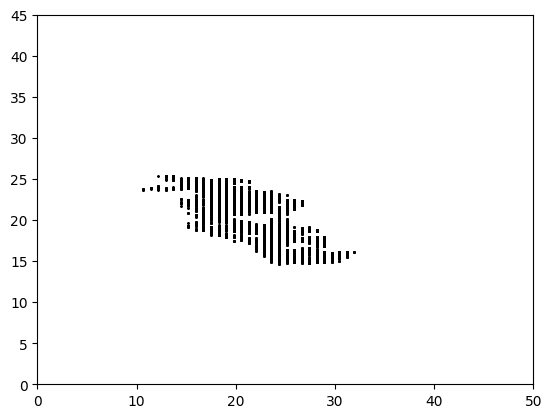

In [131]:
plt.scatter(record.ego_local_density, record.ego_local_speed, color='black', s=0.1)
plt.xlim(0, 50)
plt.ylim(0, 45)

In [71]:
desc

,ego_id,foe_id,recording_id,start,end,from,to
4,5.0,22.0,35.0,51.0,96.0,2.0,3.0
20,17.0,6.0,7.0,41.0,46.0,2.0,3.0
26,19.0,13.0,35.0,341.0,371.0,2.0,3.0
75,42.0,40.0,26.0,156.0,211.0,2.0,3.0
79,43.0,42.0,46.0,121.0,146.0,2.0,3.0
...,...,...,...,...,...,...,...
6565,2797.0,2795.0,25.0,29236.0,29271.0,2.0,3.0
6568,2804.0,2799.0,25.0,29146.0,29171.0,2.0,3.0
6570,2804.0,2799.0,25.0,29336.0,29366.0,2.0,3.0
6574,2812.0,2809.0,25.0,29001.0,29036.0,2.0,3.0


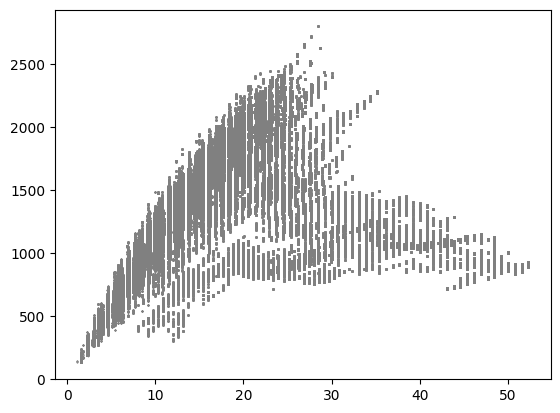

In [147]:
flow = dataset.ego_local_density * dataset.ego_local_speed * 3.6
plt.scatter(dataset.ego_local_density, flow, s=0.1, color='grey')